In [1]:
import sys
from typing import List, Dict, Tuple
from data_tools import task_map, row_operations
from utils import persistence as ps
from urllib3.response import HTTPResponse
from pandas import DataFrame, Series, read_csv, concat, Grouper, melt, merge_asof, Timedelta, DatetimeIndex
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Process, cpu_count
from error_handling import errors
from scipy import stats
from geo_merger import geo_merge, EXT
from numpy import array, empty, float64, zeros_like, triu_indices_from, log, nan, inf, asarray
from time import sleep
from functools import reduce

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
RGTRANSIT_BUCKET: str = 'rg-transit'
RGFARES_BUCKET: str = 'rg-tsfare'
RGGCABS_BUCKET: str = 'rg-gcabs'
RGYCABS_BUCKET: str = 'rg-ycabs'
RGTRAFFIC_BUCKET: str = 'rg-traffic'
REFBASE_BUCKET: str = 'ref-base'
GEOMERGED_PATH: str = 'geo-merged/'
PLOTS_BUCKET: str = 'plots'

MIN_INVW= 1 / 9.5
MAX_INVW = 1 / 0.5
RELPLOT_SZ_MULT = 1.5

BASE_COLOR='#34495E'
COLOR1='#E74C3C'
COLOR2='#2ECC71'

In [4]:
station_complex_map: Dict[str, str] = {
                                'BOWERY': 'BOWERY STREET-DELANCEY ST',
                                'WALL ST': 'WALL STREET',
                                'COURT SQ': 'COURT SQ',
                                '86 ST': '86TH STREET-4TH AVENUE',
                                'SOUTH FERRY': 'WHITEHALL STREET'
                              }
station_map: Dict[str, int] = {
                                'BOWERY': 103,
                                'WALL ST': 413,
                                'COURT SQ': 274,
                                '86 ST': 397,
                                'SOUTH FERRY': 330
                              }
weekday_map: Dict[int, str] = {
                                0 : 'Monday',
                                1 : 'Tuesday',
                                2 : 'Wednesday',
                                3 : 'Thursday',
                                4 : 'Friday',
                                5 : 'Saturday',
                                6 : 'Sunday'
                              }


In [5]:
geomerged_cabs: str = GEOMERGED_PATH+'/cabs.csv'
geomerged_traffic: str = GEOMERGED_PATH+'/traffic.csv'

# load ref-base geomerged files
filestream: HTTPResponse = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=geomerged_cabs)
dtypes: Dict[str, str] = {
    'stop_name': 'object',
    'tsstation': 'object',
    'locationid': 'int64',
    'weight': 'float64'
}
geomerged_cabs_df: DataFrame = read_csv(filestream, usecols=dtypes.keys(), encoding='utf-8', dtype=dtypes)
geomerged_cabs_df = geomerged_cabs_df[~geomerged_cabs_df['locationid'].isna()]
filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=geomerged_traffic)
dtypes = {
    'stop_name': 'object',
    'tsstation': 'object',
    'linkid': 'float64',
    'weight': 'float64'
}
geomerged_traffic_df: DataFrame = read_csv(filestream, usecols=dtypes.keys(), encoding='utf-8', dtype=dtypes)
geomerged_traffic_df = geomerged_traffic_df[~geomerged_traffic_df['linkid'].isna()]

In [6]:
task = 'pl-1W-16-17'
freq = '1D'
filterby ='all'
filterval = ''
stations = ['BOWERY', 'WALL ST', 'COURT SQ', '86 ST', 'SOUTH FERRY']
station = stations[1]

In [7]:
range_: List[str] = task_map.task_type_map[task]['range']
start_date: str = range_[0]
end_date: str = range_[1]
# determine filename of transit data for
# the current station in the rg-transit bucket
# replace '/' in station with ' '
file_path: str = freq+'/'+filterby+filterval+'/'
ts_filename: str = file_path+station.replace('/', ' ').upper()

# read transit data for station (rg-transit bucket)
filestream = ps.get_file_stream(bucket=RGTRANSIT_BUCKET, filename=ts_filename)
ts_datecols = ['datetime']
dtypes = {
         'delex': 'int64',
         'delent': 'int64'
        }
transit_df = read_csv(filestream, usecols=ts_datecols + list(dtypes.keys()),
                                 parse_dates=ts_datecols,
                                 date_parser=row_operations.parse_rg_dt,
                                 encoding='utf-8', dtype=dtypes)
transit_df = transit_df.set_index('datetime').resample(freq).sum().loc[start_date: end_date]
transit_df.head()

delex  delent
datetime                 
2016-01-01   9225   12190
2016-01-02   9084   12386
2016-01-03   8290    9832
2016-01-04  21336   27878
2016-01-05  24183   29831

In [8]:
def weighted_mean(group, weight_col):
    data_cols = [col for col in group.columns if col != weight_col]
    group_result = Series(empty(len(data_cols)), index=data_cols, dtype=float64)
    total_weight = group[weight_col].sum()
    for col in data_cols:
        group_result[col] = (group[col] * group[weight_col]).sum() / total_weight
    return group_result

In [9]:
cabs_datecols = ['dodatetime']

# determine relevant cabs files
# by finding dolocationids corresponding
# to current station from ref-base geomerged df
dolocationids = geomerged_cabs_df.loc[geomerged_cabs_df.tsstation == station][['locationid', 'weight']]

cabs_dtypes = {
    'dolocationid': 'int64',
    'passengers': 'int64',
    'distance': 'float64'
}

gcabs_df: DataFrame
gcabs_df = concat([read_csv(ps.get_file_stream(bucket=RGGCABS_BUCKET, filename=file_path+str(locationid)),
                            header=0,
                            usecols=cabs_datecols + list(cabs_dtypes.keys()),
                            parse_dates=cabs_datecols,
                            encoding='utf-8', dtype=cabs_dtypes)
                   for locationid in dolocationids['locationid']
                   if str(locationid) in ps.get_all_filenames(bucket=RGGCABS_BUCKET, path=file_path)],
                   ignore_index=True)
gcabs_df = gcabs_df.merge(dolocationids, left_on='dolocationid', right_on='locationid', how='left', copy=False).\
    drop(columns=['dolocationid', 'locationid']).drop_duplicates()

#gcabs_df = gcabs_df.set_index(cabs_datecols, 'weight').groupby(Grouper(freq=freq, level=0)).agg({'passengers': 'sum',
#                                                                                                'distance': 'sum',
#
gcabs_df = gcabs_df.set_index(cabs_datecols).groupby(Grouper(freq=freq, level=0)).\
            apply(weighted_mean, weight_col='weight').loc[start_date: end_date]
gcabs_df.head()

passengers   distance
dodatetime                       
2016-01-01   12.997514  26.730037
2016-01-02   12.072977  22.568372
2016-01-03   11.383797  22.045298
2016-01-04   12.559591  21.286322
2016-01-05   12.067423  21.081923

In [10]:
ycabs_df: DataFrame
ycabs_df = concat([read_csv(ps.get_file_stream(bucket=RGYCABS_BUCKET, filename=file_path+str(locationid)),
                            header=0,
                            usecols=cabs_datecols + list(cabs_dtypes.keys()),
                            parse_dates=cabs_datecols,
                            encoding='utf-8', dtype=cabs_dtypes)
                   for locationid in dolocationids['locationid']
                   if str(locationid) in ps.get_all_filenames(bucket=RGYCABS_BUCKET, path=file_path)],
                  ignore_index=True)
ycabs_df = ycabs_df.merge(dolocationids, left_on='dolocationid', right_on='locationid', how='left',
                          copy=False). \
    drop(columns=['dolocationid', 'locationid']).drop_duplicates()
#ycabs_df = ycabs_df.set_index(cabs_datecols, 'weight').groupby(Grouper(freq='D', level=0)).agg({'passengers': 'sum',
#                                                                                                'distance': 'sum',
#                                                                                                 'weight': 'first'}).loc[
#           start_date: end_date]
ycabs_df = ycabs_df.set_index(cabs_datecols).groupby(Grouper(freq=freq, level=0)).\
            apply(weighted_mean, weight_col='weight').loc[start_date: end_date]

ycabs_df.head()

passengers     distance
dodatetime                         
2016-01-01   37.098466    70.927643
2016-01-02   46.104289    82.708230
2016-01-03   41.876620    85.435436
2016-01-04   47.522867  1943.225535
2016-01-05   49.660423   225.116662

In [11]:
traffic_df: DataFrame
traffic_datecols = ['datetime']
linkids = geomerged_traffic_df.loc[geomerged_traffic_df.tsstation == station][['linkid', 'weight']]

if linkids.size > 0:
    traffic_dtypes = {
        'linkid': 'int64',
        'speed': 'float64',
        'traveltime': 'float64'
    }
    traffic_cols = list(traffic_dtypes.keys())
    traffic_df = concat([read_csv(ps.get_file_stream(bucket=RGTRAFFIC_BUCKET, filename=file_path+str(int(linkid))),
                                  header=0,
                                  usecols=traffic_datecols + traffic_cols,
                                  parse_dates=traffic_datecols,
                                  encoding='utf-8', dtype=traffic_dtypes)
                        for linkid in linkids['linkid']
                       if str(int(linkid)) in ps.get_all_filenames(bucket=RGTRAFFIC_BUCKET, path=file_path)],
                      ignore_index=True)
    traffic_df = traffic_df.merge(linkids, on='linkid', how='left', copy=False).drop(columns=['linkid']).drop_duplicates()
    #traffic_df = traffic_df.set_index(traffic_datecols, 'weight').groupby(Grouper(freq=freq, level=0)).agg({'speed': 'mean',
    #                                                                                                'traveltime': 'mean',
    #
    traffic_df = traffic_df.set_index(traffic_datecols).groupby(Grouper(freq=freq, level=0)).\
                apply(weighted_mean, weight_col='weight').loc[start_date: end_date]

traffic_df.head()

speed  traveltime
datetime                         
2016-01-01  45.742034  138.480422
2016-01-02  44.023684  151.110483
2016-01-03  44.635034  153.356573
2016-01-04  41.335783  170.452128
2016-01-05  41.328925  178.088024

In [12]:
# gas
gas_file: str ='gas.csv'
filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=gas_file)
dtypes = {
    'price': 'float64'
}
gas_datecols = ['date']
gas_df: DataFrame = read_csv(filestream, usecols=list(dtypes.keys())+gas_datecols, parse_dates=gas_datecols, encoding='utf-8', dtype=dtypes)
gas_df = gas_df.set_index(gas_datecols).loc[start_date: end_date]
# drop outliers
gas_df = row_operations.drop_outliers(gas_df, 'price')
# gas data is weekly reported on Mondays
# shift dates from Monday to end of week (1W resampled data uses end-ofweek i.e. Sunday) used for rest of the data
# shift back by one day
#td = Timedelta(-1, unit='d')
#gas_df.index = gas_df.index + td
gas_df.head()

price
date             
2016-01-04  2.147
2016-01-11  2.123
2016-01-18  2.056
2016-01-25  2.027
2016-02-01  1.997

In [13]:
ix = DatetimeIndex(start=start_date, end=end_date, freq='D')
gas_df = gas_df.reindex(ix).interpolate(method='linear', limit_direction='both')
gas_df.head()

price
2016-01-01  2.147000
2016-01-02  2.147000
2016-01-03  2.147000
2016-01-04  2.147000
2016-01-05  2.143571

In [14]:
# weather
weather_file: str ='weather.csv'
filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=weather_file)
dtypes = {
        'prcp': 'float64',
        'snow': 'float64',
        'temp': 'float64'
}
weather_datecols = ['date']
weather_df: DataFrame = read_csv(filestream, usecols=list(dtypes.keys())+weather_datecols, parse_dates=weather_datecols, encoding='utf-8', dtype=dtypes)
weather_df = weather_df.set_index(weather_datecols).loc[start_date: end_date]
# weather data is daily
# filter by day (filterby and filterval)
#print(filterval)
#weather_df = weather_df.loc[weather_df.index.dayofweek == int(filterval)]
# shift dates from filterval day to end of week (1W resampled data uses end-ofweek i.e. Sunday) used for rest of the data
#td = Timedelta(-1-int(filterval), unit='d')
#weather_df.index = weather_df.index + td
weather_df.head()

prcp  snow  temp
date                        
2016-01-01   0.0   0.0  38.0
2016-01-02   0.0   0.0  36.0
2016-01-03   0.0   0.0  40.0
2016-01-04   0.0   0.0  25.0
2016-01-05   0.0   0.0  20.0

In [15]:
cabs_df= DataFrame()
cabs_df['passengers'] = gcabs_df['passengers'] + ycabs_df['passengers']
cabs_df['distance'] = gcabs_df['distance'] + ycabs_df['distance']

In [16]:
df_merged = concat([transit_df, cabs_df, traffic_df, gas_df, weather_df], axis=1)
df_merged.head()

delex   delent  passengers     distance      speed  traveltime  \
2016-01-01   9225.0  12190.0   50.095981    97.657679  45.742034  138.480422   
2016-01-02   9084.0  12386.0   58.177266   105.276602  44.023684  151.110483   
2016-01-03   8290.0   9832.0   53.260417   107.480734  44.635034  153.356573   
2016-01-04  21336.0  27878.0   60.082458  1964.511857  41.335783  170.452128   
2016-01-05  24183.0  29831.0   61.727846   246.198585  41.328925  178.088024   

               price  prcp  snow  temp  
2016-01-01  2.147000   0.0   0.0  38.0  
2016-01-02  2.147000   0.0   0.0  36.0  
2016-01-03  2.147000   0.0   0.0  40.0  
2016-01-04  2.147000   0.0   0.0  25.0  
2016-01-05  2.143571   0.0   0.0  20.0

In [17]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-01-01 to 2017-12-31
Freq: D
Data columns (total 10 columns):
delex         729 non-null float64
delent        729 non-null float64
passengers    731 non-null float64
distance      731 non-null float64
speed         626 non-null float64
traveltime    626 non-null float64
price         731 non-null float64
prcp          731 non-null float64
snow          731 non-null float64
temp          731 non-null float64
dtypes: float64(10)
memory usage: 62.8 KB


In [18]:
len(df_merged.loc[df_merged.isna().any(axis=1).values])

107

In [19]:
#df_merged = df_merged.dropna()
df_merged = df_merged.interpolate(method='linear', limit_direction='both')
len(df_merged.loc[df_merged.isna().any(axis=1).values])

0

In [20]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-01-01 to 2017-12-31
Freq: D
Data columns (total 10 columns):
delex         731 non-null float64
delent        731 non-null float64
passengers    731 non-null float64
distance      731 non-null float64
speed         731 non-null float64
traveltime    731 non-null float64
price         731 non-null float64
prcp          731 non-null float64
snow          731 non-null float64
temp          731 non-null float64
dtypes: float64(10)
memory usage: 62.8 KB


## EDA and Stationarity Tests

In [53]:
sns.set_style('darkgrid')
plots_folder = '../plots/'

In [204]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, series_name='data'):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig, ax = plt.subplots(figsize=(15,6))
    orig = ax.plot(timeseries, color='blue',label='Original')
    mean = ax.plot(rolmean, color='red', label='Rolling Mean')
    std = ax.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    ax.set_xlabel('time')
    ax.set_ylabel(series_name)
    plt.show(block=False)
    fig.savefig(plots_folder+'ts_'+series_name+'.png')
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [54]:
def make_acf_plot(series, lag=50, series_name='data'):
    fig, ax = plt.subplots(2,1, figsize=(15,12))
    plot_acf(series, ax=ax[0], lags=lag)
    plot_pacf(series, ax=ax[1], lags=lag)
    ax[0].set_xlabel('time')
    ax[0].set_ylabel(series_name+' auto-correlation')
    ax[0].set_title('Auto-correlation Plot')
    ax[1].set_xlabel('time')
    ax[1].set_ylabel(series_name+' partial auto-correlation')
    ax[1].set_title('Partial Auto-correlation Plot')
    plt.show()
    fig.savefig(plots_folder+series_name+'_acf.png')
    return

In [55]:
def make_hist_plot(series, series_name='data'):
    fig, ax = plt.subplots(figsize=(15,6))
    hist = ax.hist(series, bins=50)
    ax.set_xlabel(series_name)
    ax.set_ylabel('frequency')
    ax.set_title('Histogram')
    plt.show()
    fig.savefig(plots_folder+series_name+'_hist.png')
    return    

In [205]:
def make_ts_plots(series, lag=50, series_name='data'):
    test_stationarity(series, series_name)
    make_hist_plot(series, series_name)
    make_acf_plot(series, lag,series_name)    
    return

In [27]:
def smooth_diff(series, diff_lag=1):
    series = series.diff(periods=diff_lag)
    return series

In [28]:
def drop_inf_na(series):    
    series = series.replace([inf, -inf], nan).dropna()
    return series

### Transit Passengers (exiting the station)

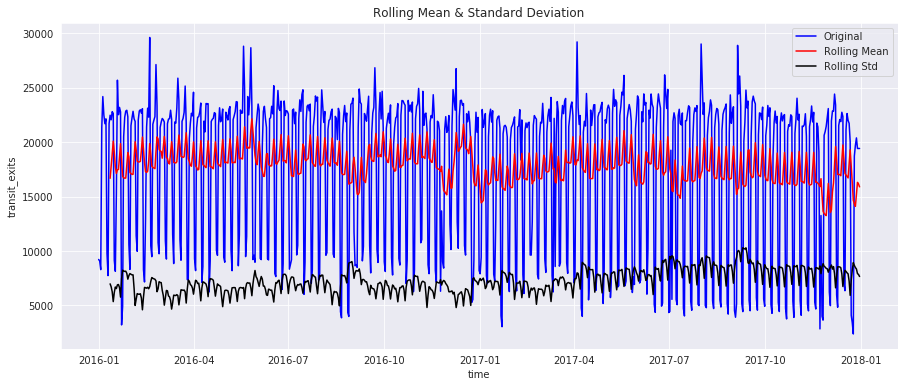

Results of Dickey-Fuller Test:
Test Statistic                  -4.346754
p-value                          0.000368
#Lags Used                      20.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


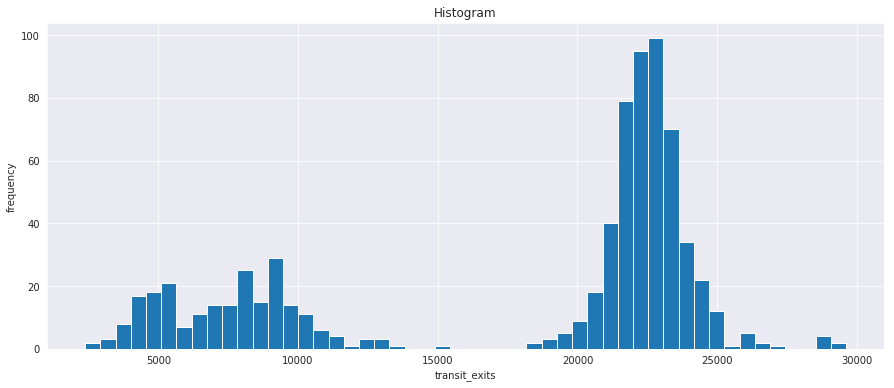

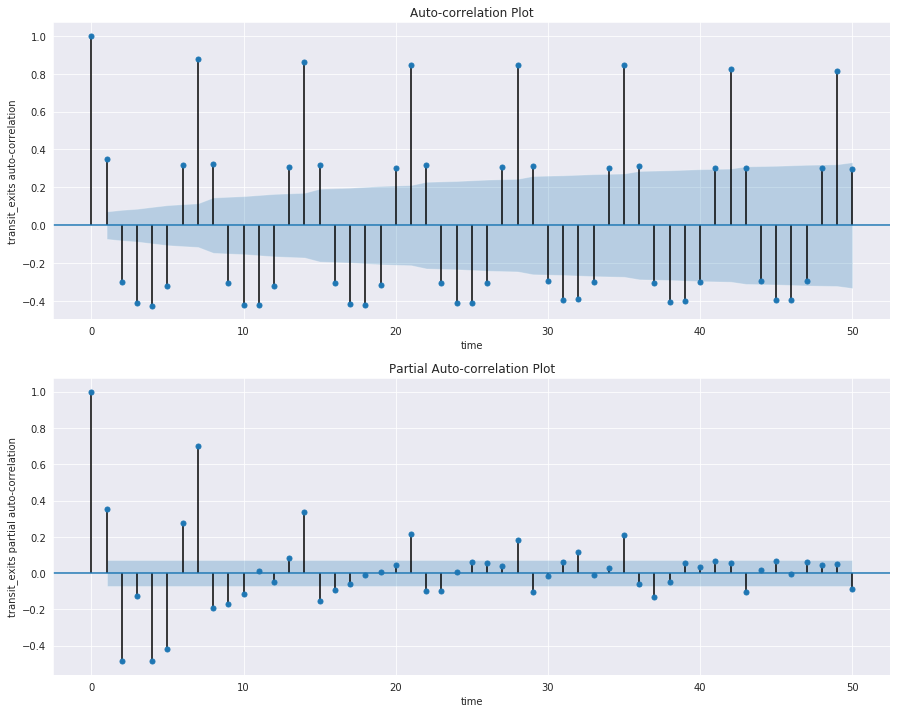

In [206]:
make_ts_plots(df_merged['delex'], series_name='transit_exits')

#### Analyzing the differenced series (lag=7)

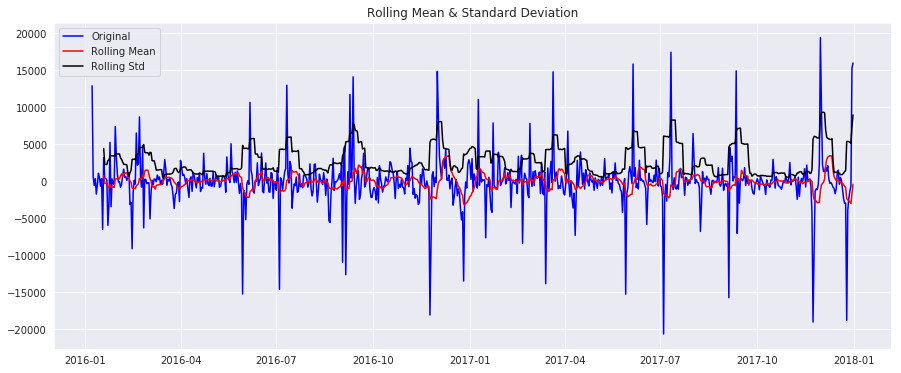

Results of Dickey-Fuller Test:
Test Statistic                -1.054644e+01
p-value                        8.389342e-19
#Lags Used                     2.000000e+01
Number of Observations Used    7.030000e+02
Critical Value (1%)           -3.439686e+00
Critical Value (5%)           -2.865660e+00
Critical Value (10%)          -2.568964e+00
dtype: float64


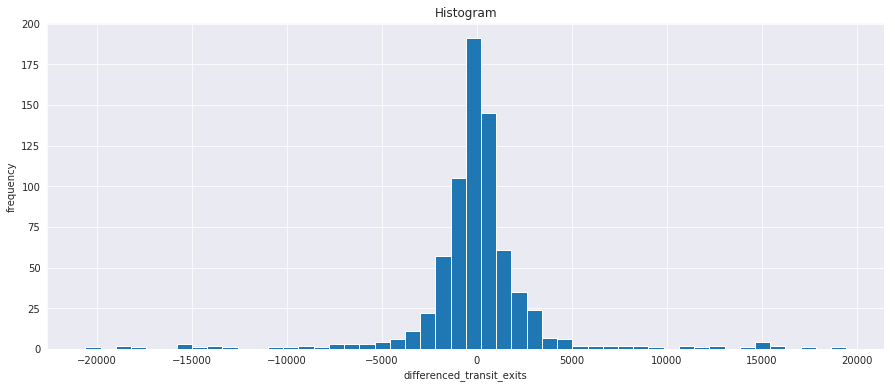

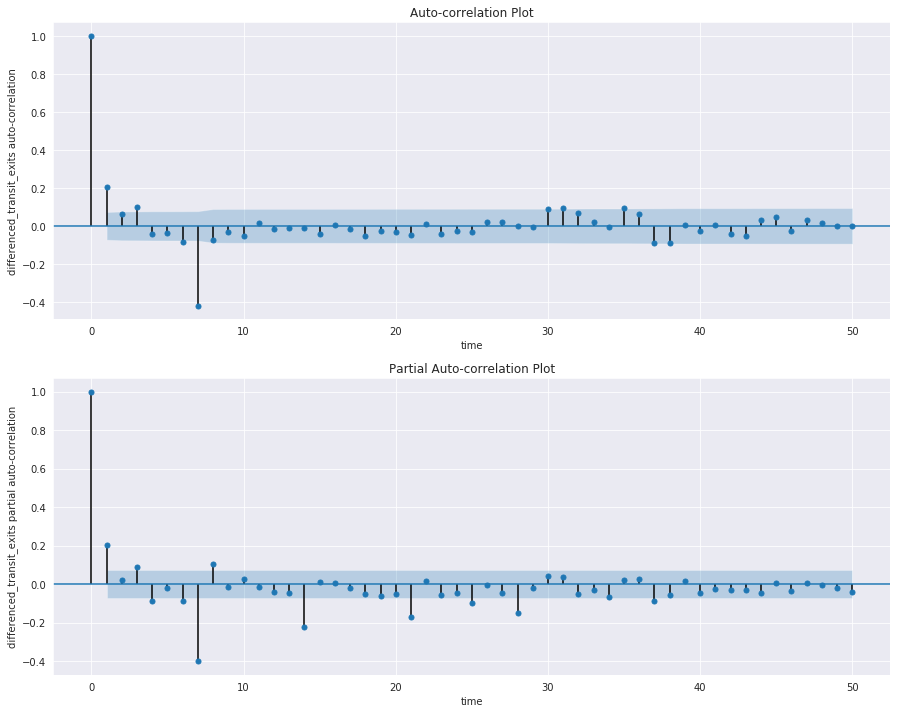

In [57]:
make_ts_plots(drop_inf_na(smooth_diff(df_merged['delex'], diff_lag=7)), series_name='differenced_transit_exits')

#### Local Trend

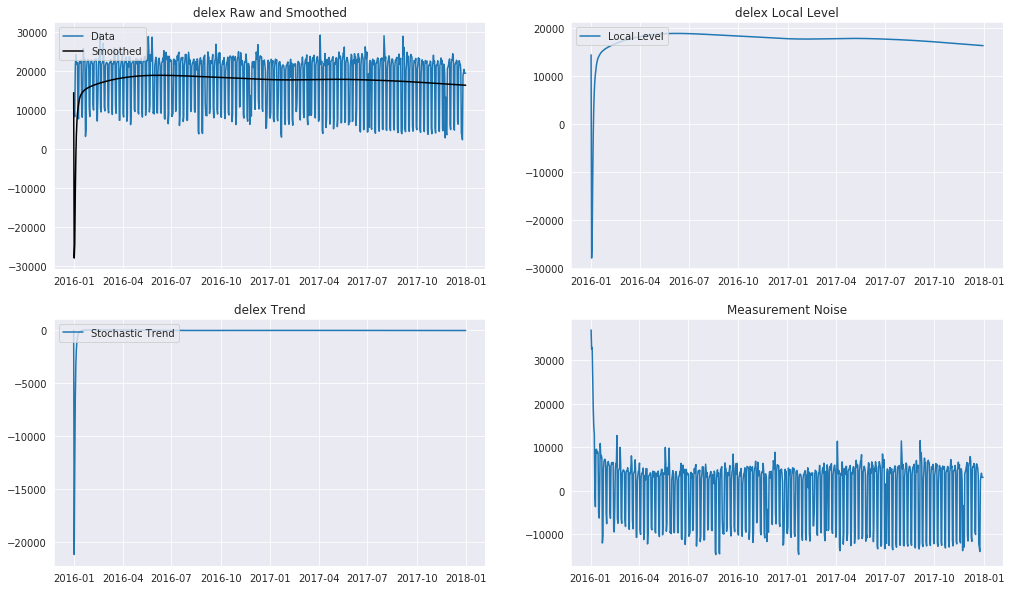

In [52]:
from pyflux import LLT
delex_llt_model = LLT(data=df_merged, target='delex')
delex_llt_model.fit()
delex_llt_model.plot_fit(intervals=False,figsize=(17,10))

### Transit Passengers (entering the station)

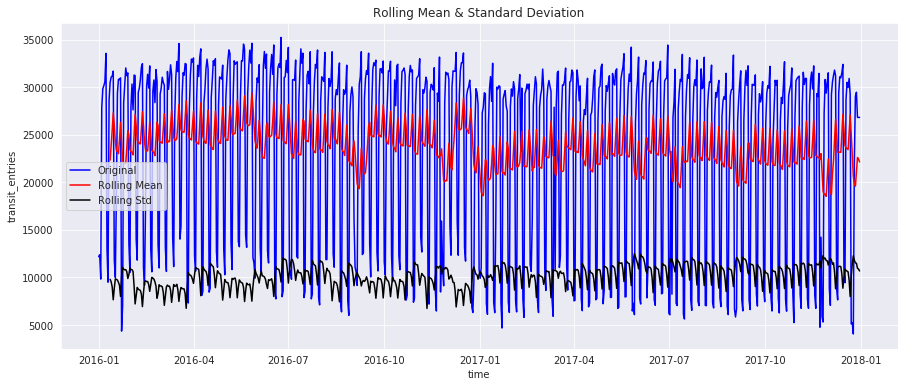

Results of Dickey-Fuller Test:
Test Statistic                  -4.158597
p-value                          0.000774
#Lags Used                      20.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


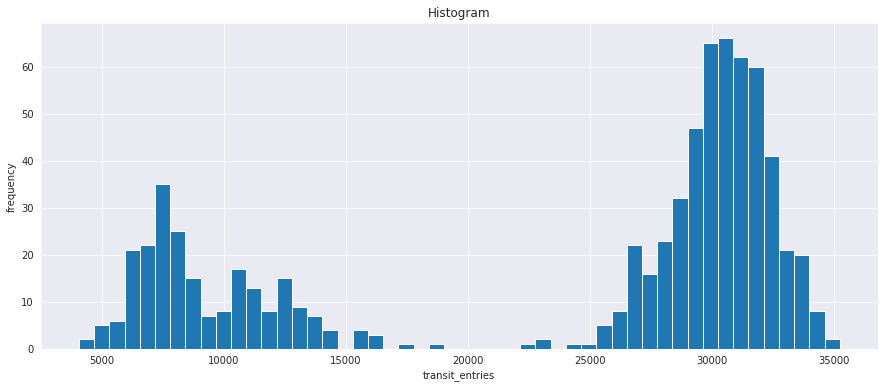

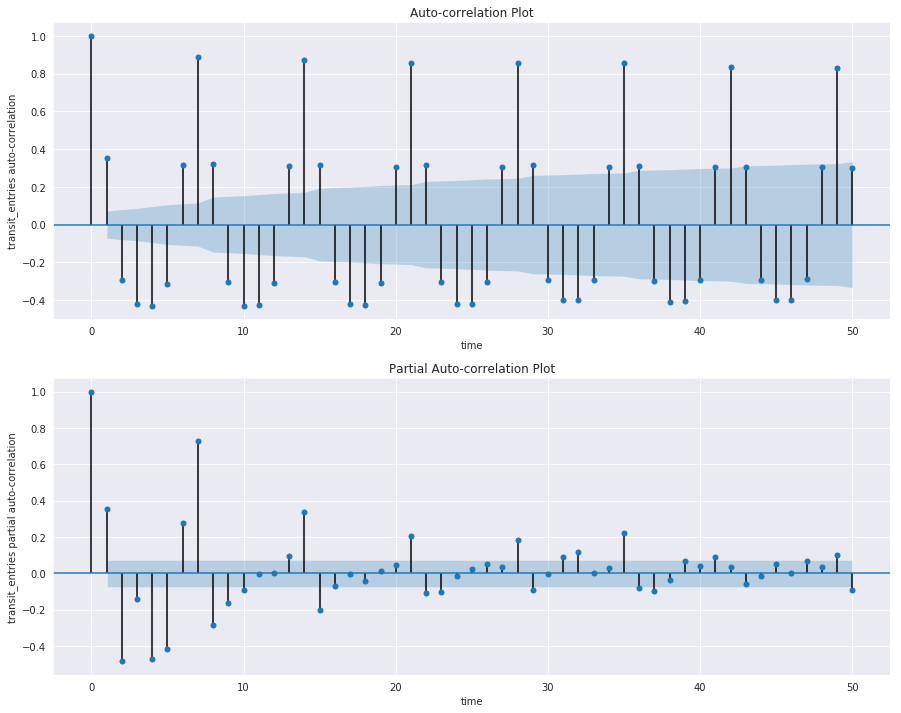

In [207]:
make_ts_plots(df_merged['delent'], series_name='transit_entries')

In [59]:
from numpy import std
print('standard deviation of un-differenced transit entries {:f}'.format(std(df_merged['delent'])))

standard deviation of un-differenced transit entries 10021.516597


#### Analyzing the differenced series (lag=7)

In [60]:
series = drop_inf_na(smooth_diff(df_merged['delent'], diff_lag=7))

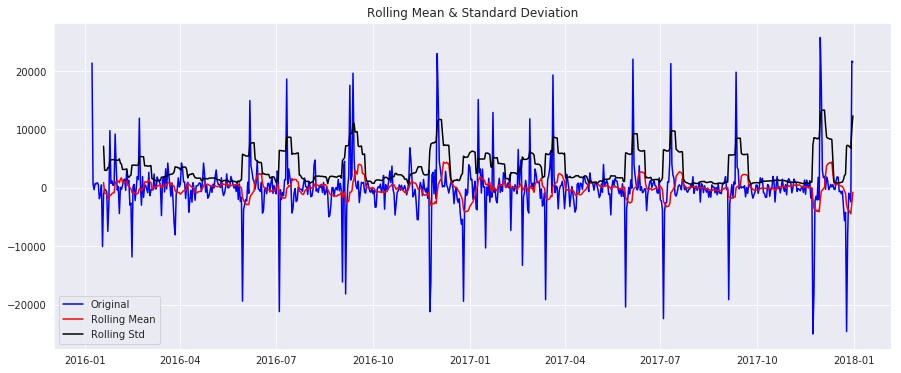

Results of Dickey-Fuller Test:
Test Statistic                -9.919451e+00
p-value                        3.018138e-17
#Lags Used                     2.000000e+01
Number of Observations Used    7.030000e+02
Critical Value (1%)           -3.439686e+00
Critical Value (5%)           -2.865660e+00
Critical Value (10%)          -2.568964e+00
dtype: float64


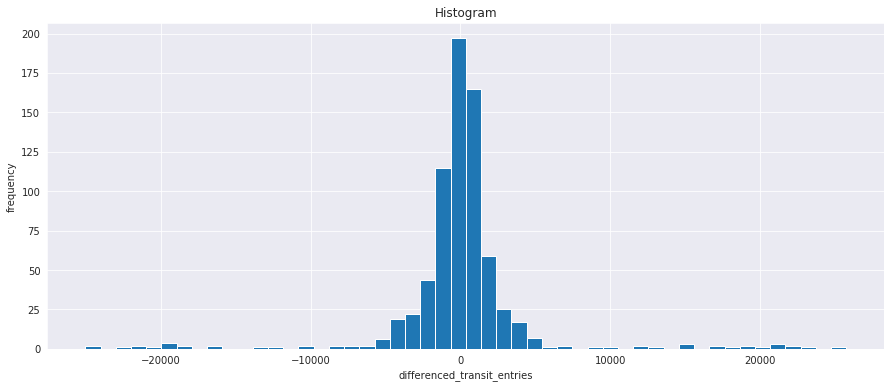

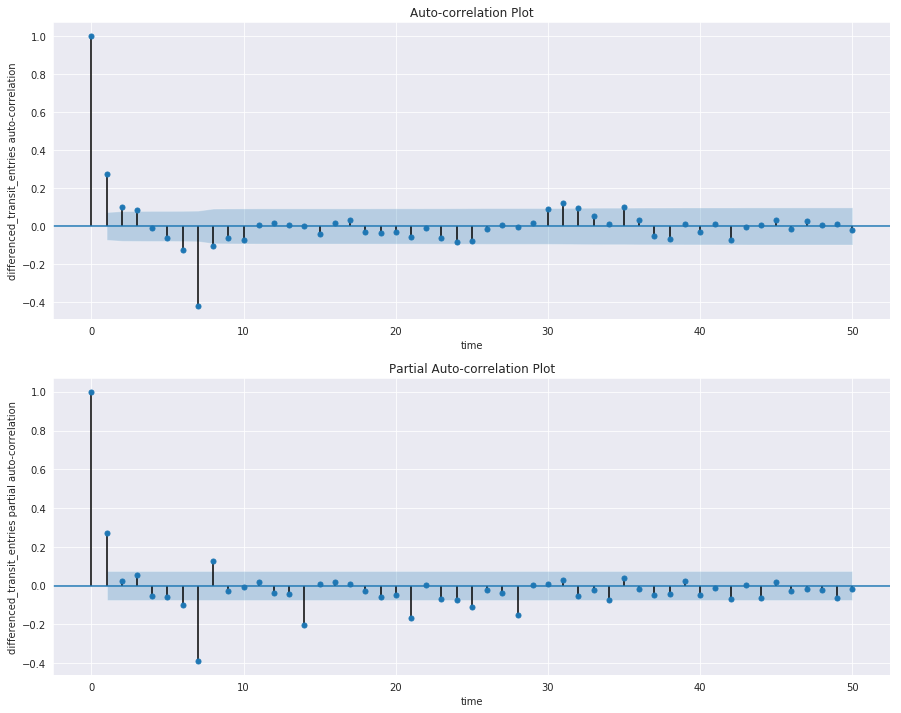

In [61]:
make_ts_plots(series, series_name='differenced_transit_entries')

In [62]:
from numpy import std
print('standard deviation of first-order differenced transit entries (lag=7) {:f}'.format(std(series)))

standard deviation of first-order differenced transit entries (lag=7) 4653.286932


#### Local Trend

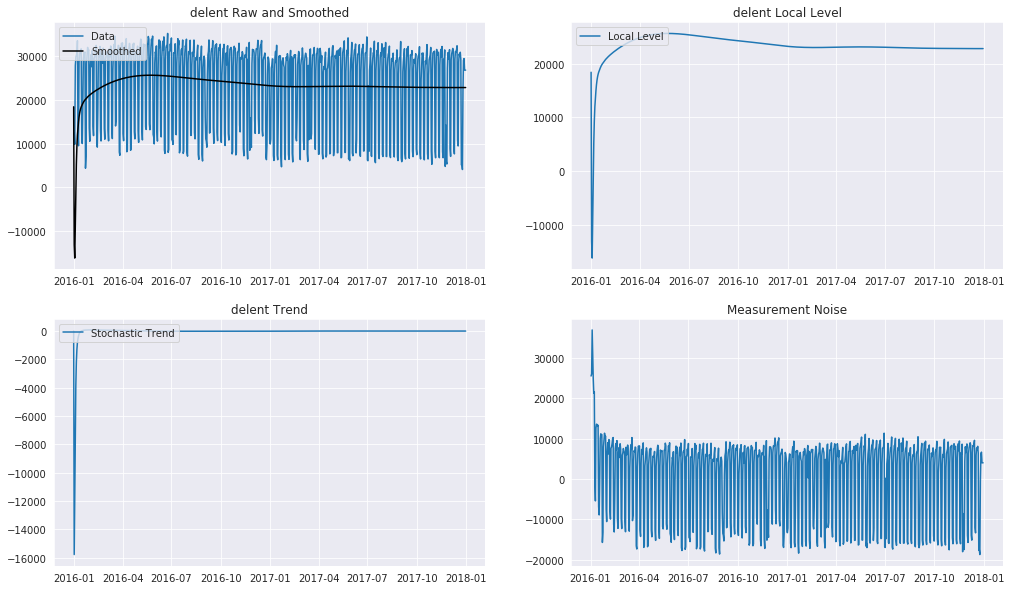

In [63]:
delent_llt_model = LLT(data=df_merged, target='delent')
delent_llt_model.fit()
delent_llt_model.plot_fit(intervals=False,figsize=(17,10))

### Cab Rides

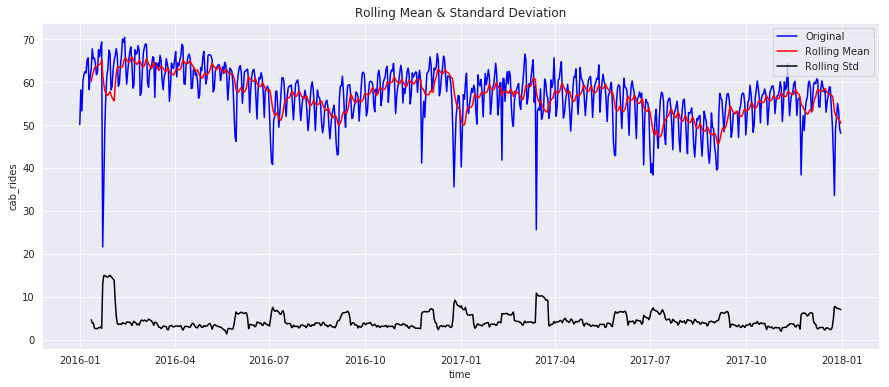

Results of Dickey-Fuller Test:
Test Statistic                  -2.457215
p-value                          0.126234
#Lags Used                      20.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


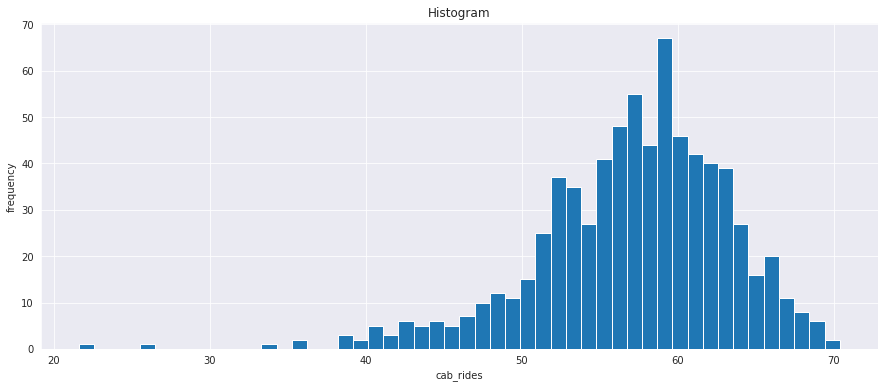

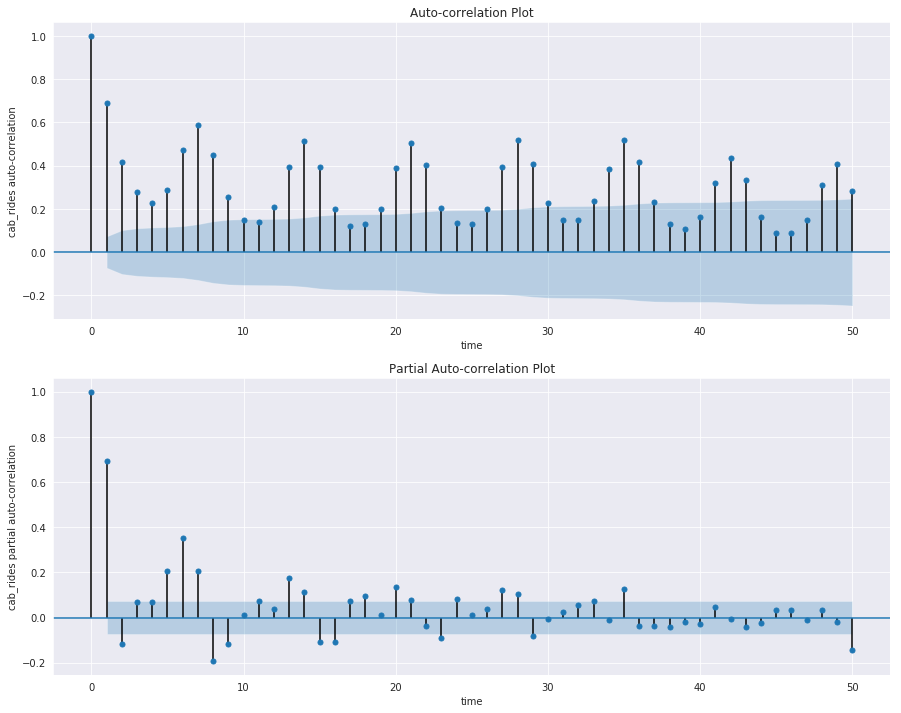

In [208]:
make_ts_plots(df_merged['passengers'], series_name='cab_rides')

In [80]:
print('standard deviation of un-differenced cab rides {:f}'.format(std(df_merged['passengers'])))

standard deviation of un-differenced cab rides 6.265045


#### Analyzing the differenced series (lag=7)

In [81]:
series = drop_inf_na(smooth_diff(df_merged['passengers'], diff_lag=7))

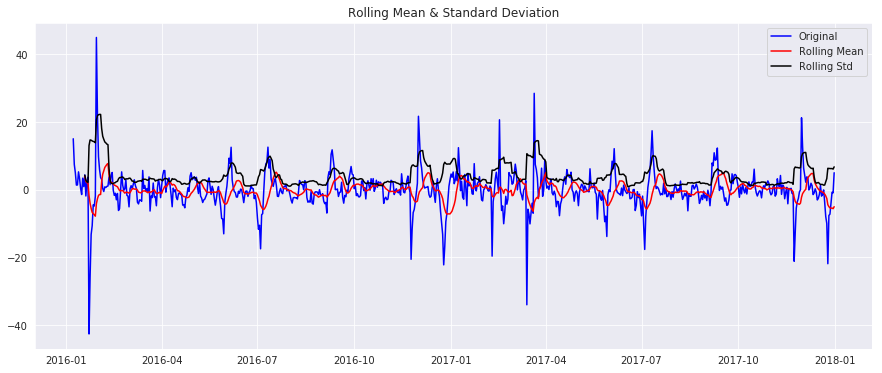

Results of Dickey-Fuller Test:
Test Statistic                -9.834326e+00
p-value                        4.941454e-17
#Lags Used                     2.000000e+01
Number of Observations Used    7.030000e+02
Critical Value (1%)           -3.439686e+00
Critical Value (5%)           -2.865660e+00
Critical Value (10%)          -2.568964e+00
dtype: float64


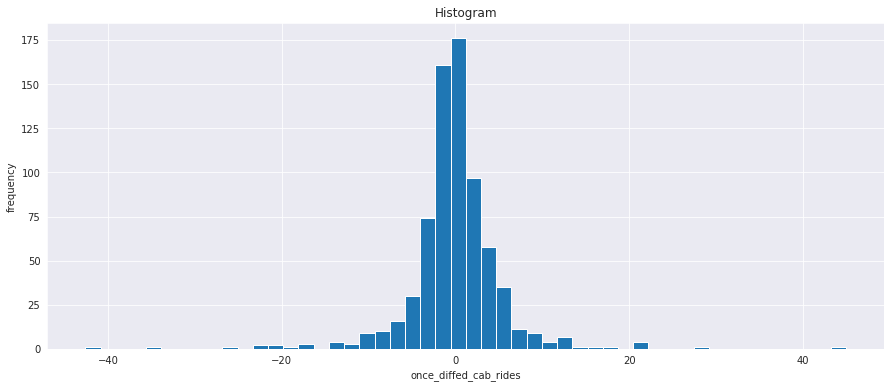

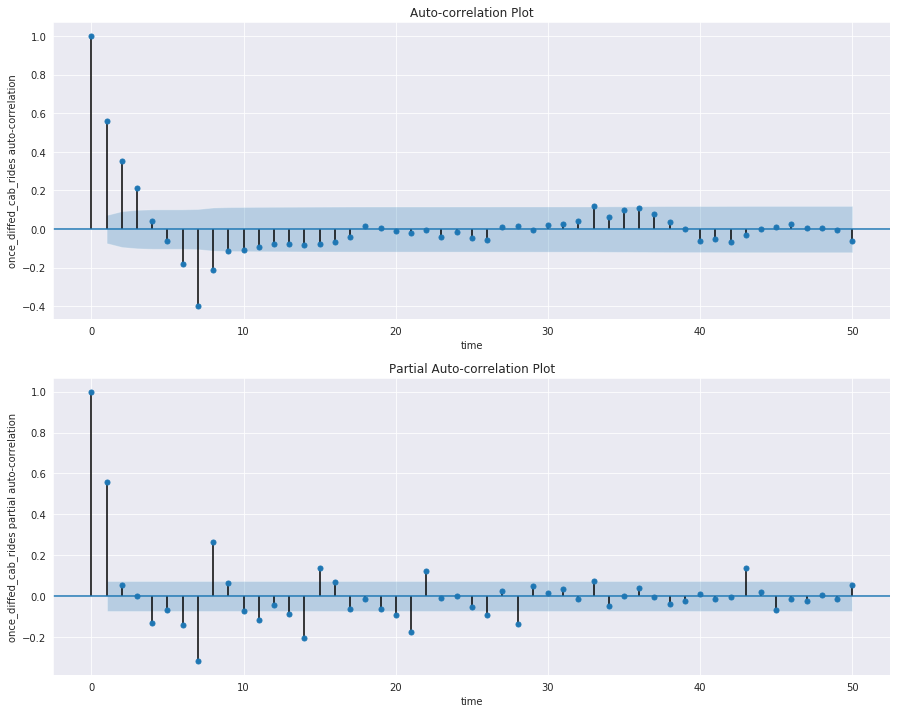

In [82]:
make_ts_plots(series, series_name='once_diffed_cab_rides')

In [83]:
print('standard deviation of first-order differenced cab rides (lag=7) {:f}'.format(std(series)))

standard deviation of first-order differenced cab rides (lag=7) 5.590606


#### Analyzing the second-order differenced series (lag=7, 1)

In [84]:
series = drop_inf_na(smooth_diff(drop_inf_na(smooth_diff(df_merged['passengers'], diff_lag=7)), diff_lag=1))

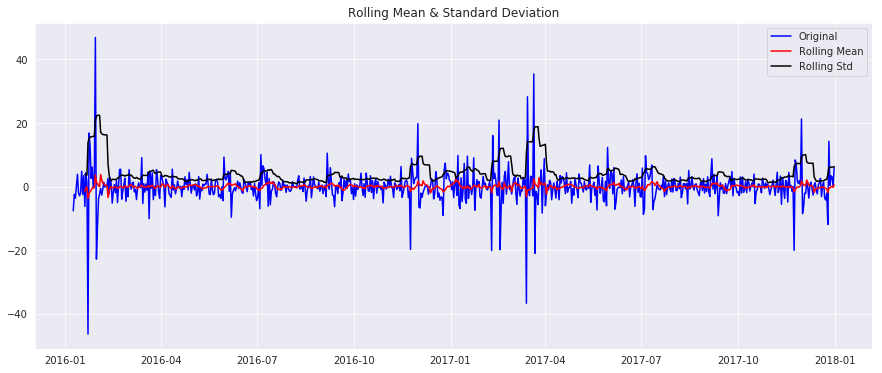

Results of Dickey-Fuller Test:
Test Statistic                -1.081283e+01
p-value                        1.889542e-19
#Lags Used                     2.000000e+01
Number of Observations Used    7.020000e+02
Critical Value (1%)           -3.439700e+00
Critical Value (5%)           -2.865666e+00
Critical Value (10%)          -2.568967e+00
dtype: float64


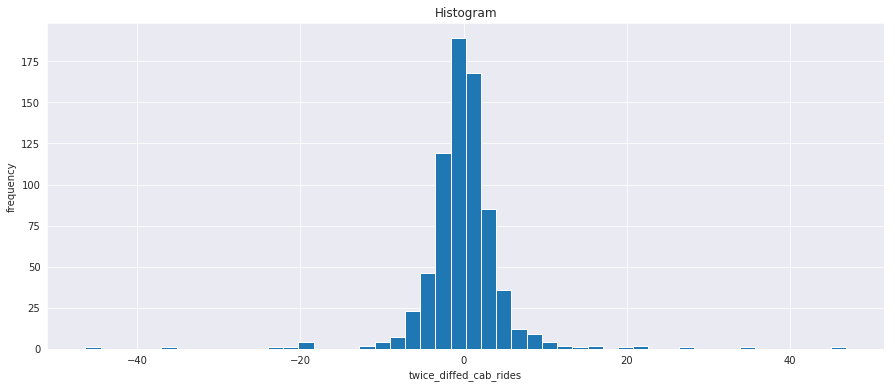

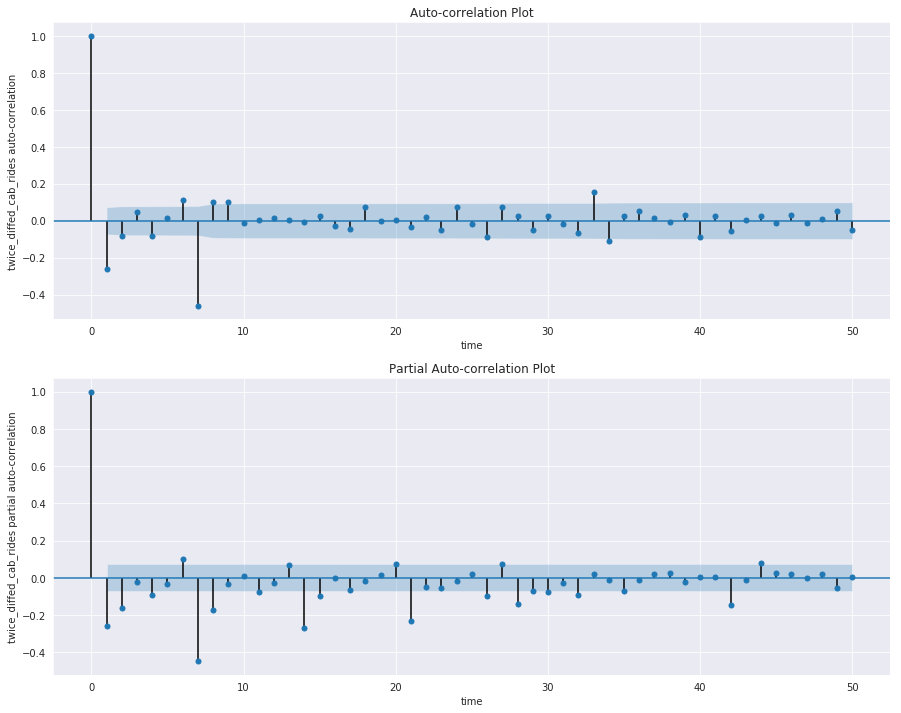

In [85]:
make_ts_plots(series, series_name='twice_diffed_cab_rides')

In [86]:
print('standard deviation of second-order differenced cab rides (lag=7, 1) {:f}'.format(std(series)))

standard deviation of second-order differenced cab rides (lag=7, 1) 5.224780


#### Local Trend

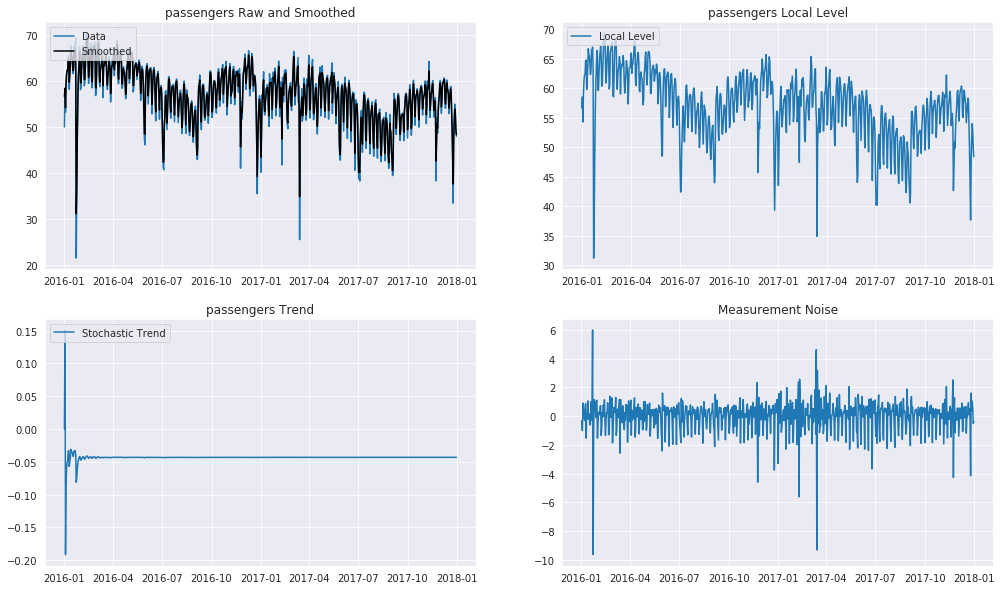

In [72]:
from pyflux import LocalTrend, Normal
#cabs_llt_model = LLT(data=df_merged, target='passengers')
cabs_llt_model = LocalTrend(data=df_merged, integ=0, target='passengers', family=Normal())
cabs_llt_model.fit()
cabs_llt_model.plot_fit(intervals=False,figsize=(17,10))

### Traffic Speed

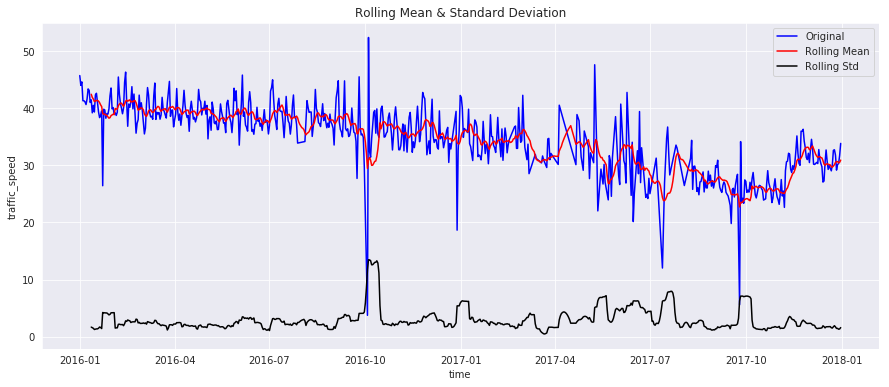

Results of Dickey-Fuller Test:
Test Statistic                  -2.204295
p-value                          0.204690
#Lags Used                      13.000000
Number of Observations Used    717.000000
Critical Value (1%)             -3.439503
Critical Value (5%)             -2.865579
Critical Value (10%)            -2.568921
dtype: float64


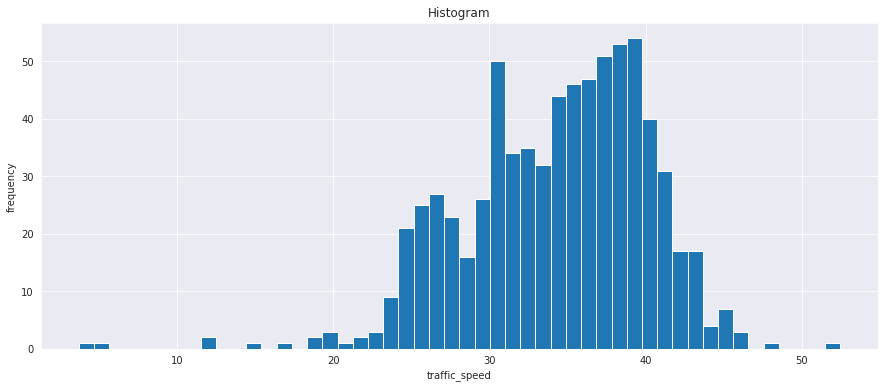

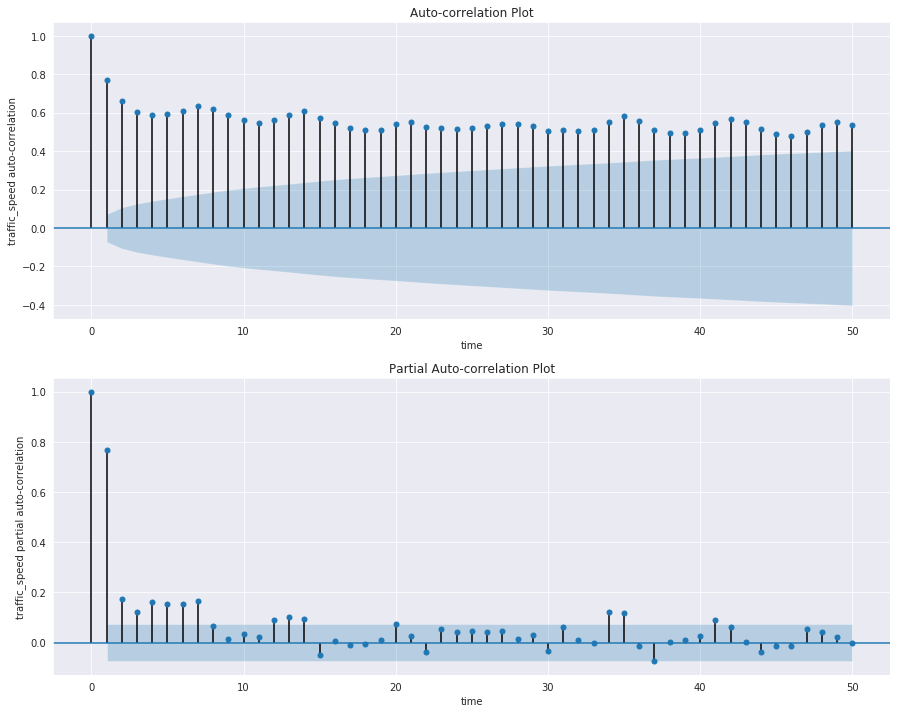

In [209]:
make_ts_plots(df_merged['speed'], series_name='traffic_speed')

In [88]:
print('standard deviation of un-differenced traffic speed {:f}'.format(std(df_merged['speed'])))

standard deviation of un-differenced traffic speed 5.891836


#### Analyzing the differenced series (lag=1)

In [89]:
series = drop_inf_na(smooth_diff(df_merged['speed'], diff_lag=1))

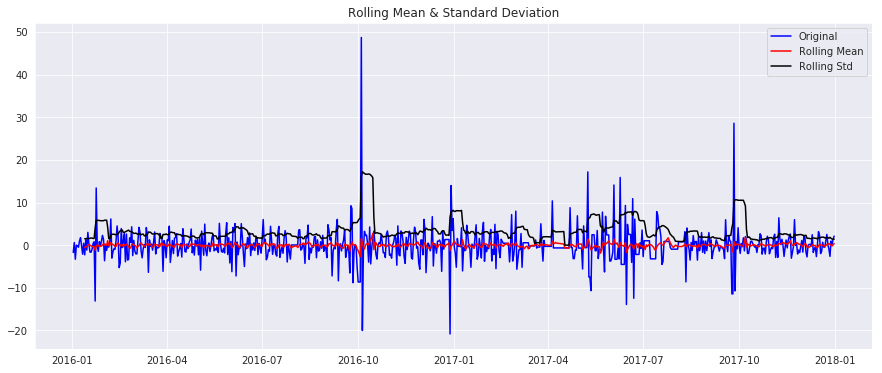

Results of Dickey-Fuller Test:
Test Statistic                -1.262513e+01
p-value                        1.547570e-23
#Lags Used                     1.200000e+01
Number of Observations Used    7.170000e+02
Critical Value (1%)           -3.439503e+00
Critical Value (5%)           -2.865579e+00
Critical Value (10%)          -2.568921e+00
dtype: float64


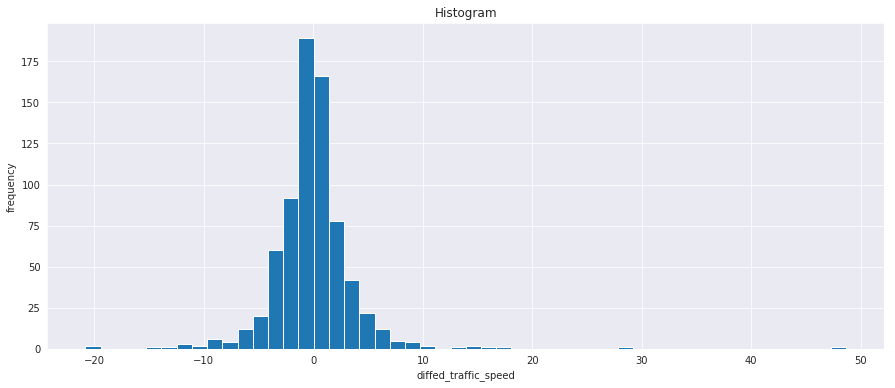

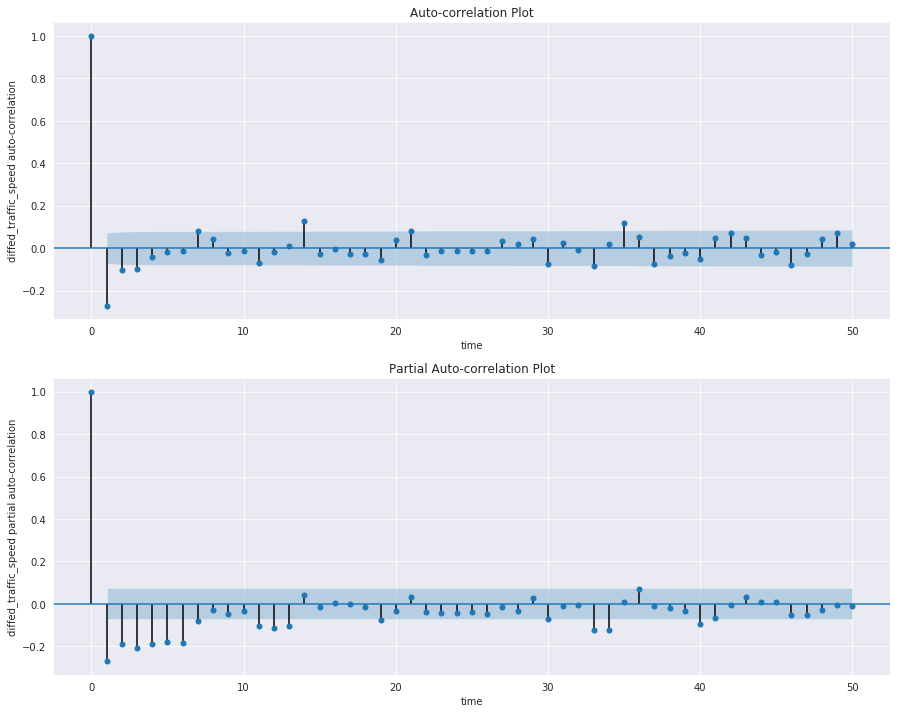

In [90]:
make_ts_plots(series, series_name='diffed_traffic_speed')

In [91]:
print('standard deviation of first-order differenced traffic speed (lag=1) {:f}'.format(std(series)))

standard deviation of first-order differenced traffic speed (lag=1) 3.988434


#### Local Trend

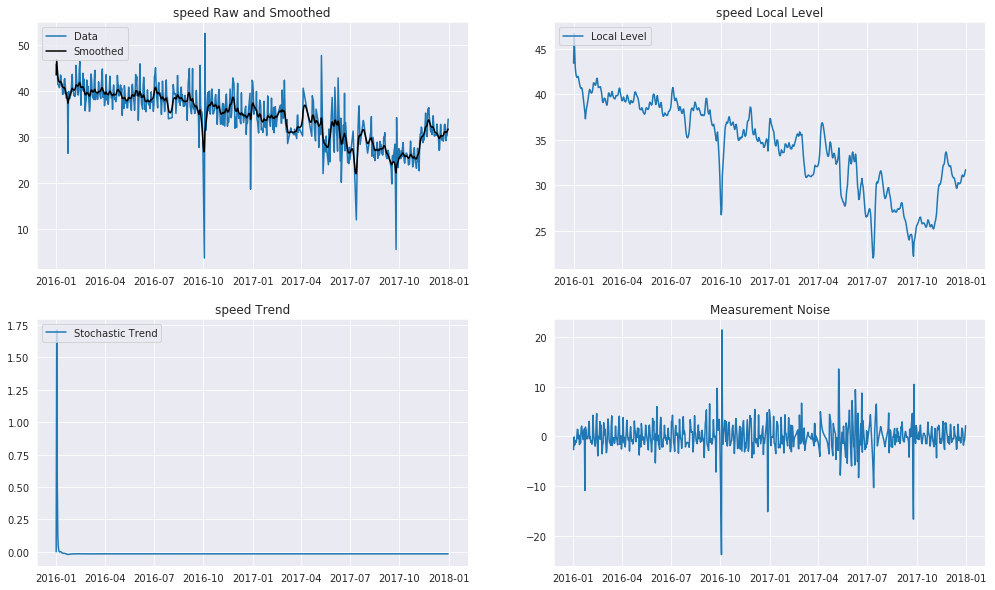

In [78]:
#traffic_llt_model = LLT(data=df_merged, target='speed')
traffic_llt_model = LocalTrend(data=df_merged, integ=0, target='speed', family=Normal())
traffic_llt_model.fit()
traffic_llt_model.plot_fit(intervals=False,figsize=(17,10))

### Gas Price

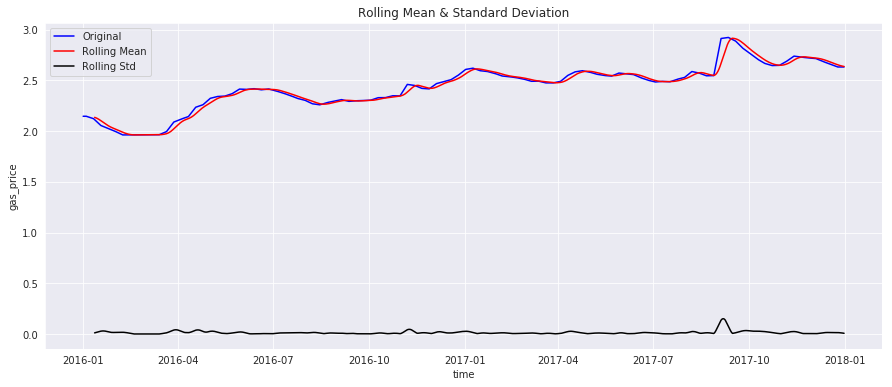

Results of Dickey-Fuller Test:
Test Statistic                  -1.954157
p-value                          0.307028
#Lags Used                      15.000000
Number of Observations Used    715.000000
Critical Value (1%)             -3.439529
Critical Value (5%)             -2.865591
Critical Value (10%)            -2.568927
dtype: float64


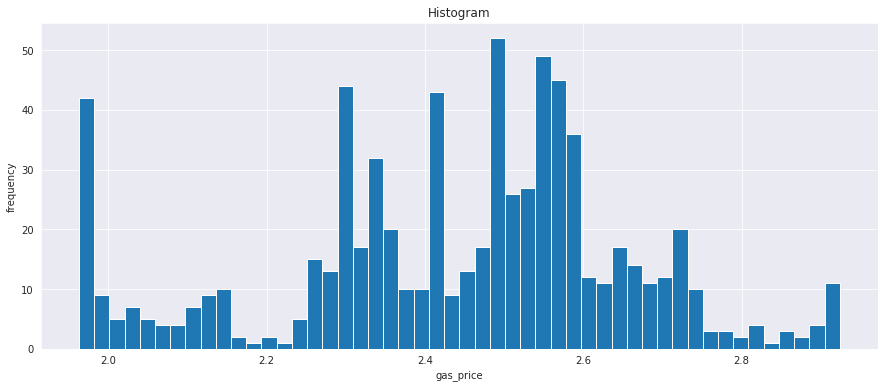

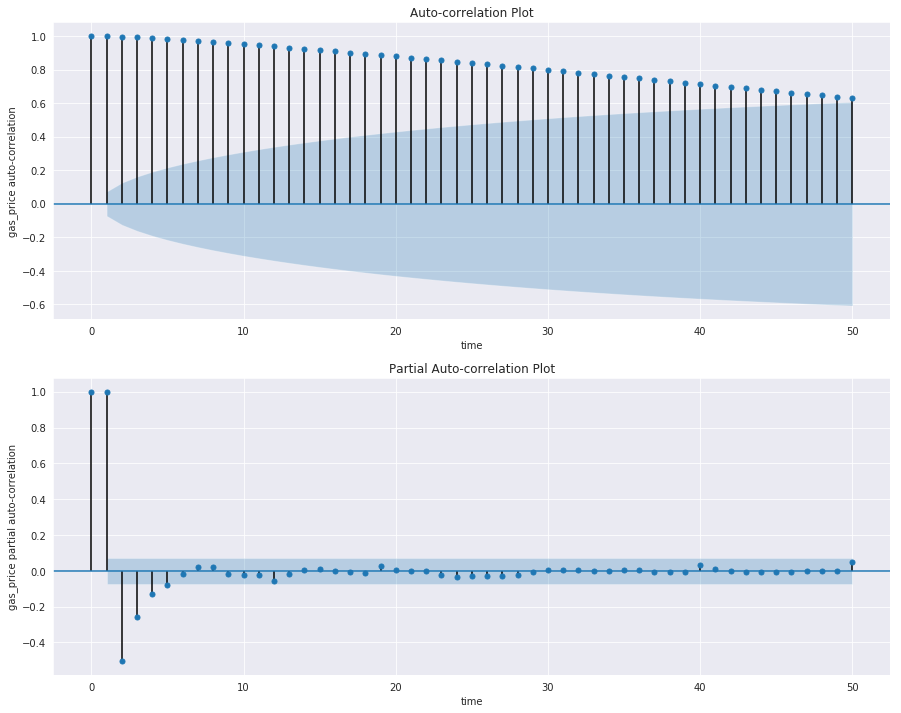

In [210]:
make_ts_plots(df_merged['price'], lag=50, series_name='gas_price')

In [93]:
print('standard deviation of un-differenced gas price {:f}'.format(std(df_merged['price'])))

standard deviation of un-differenced gas price 0.219972


#### Analyzing the differenced series (lag=1)

In [212]:
series = drop_inf_na(smooth_diff(df_merged['price'], diff_lag=1))

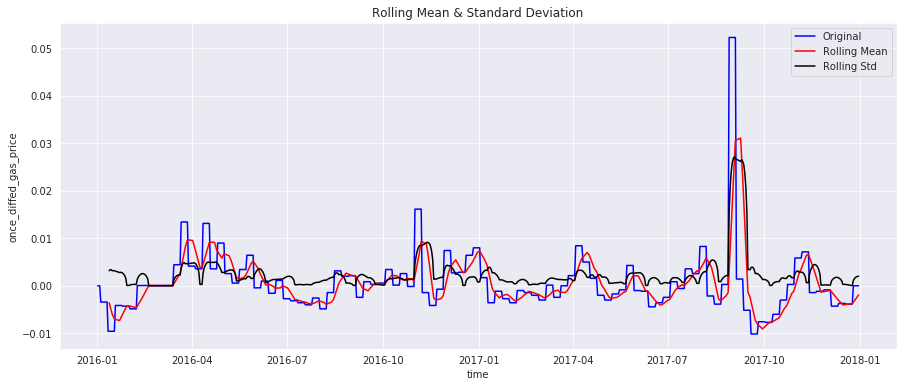

Results of Dickey-Fuller Test:
Test Statistic                  -5.197261
p-value                          0.000009
#Lags Used                      14.000000
Number of Observations Used    715.000000
Critical Value (1%)             -3.439529
Critical Value (5%)             -2.865591
Critical Value (10%)            -2.568927
dtype: float64


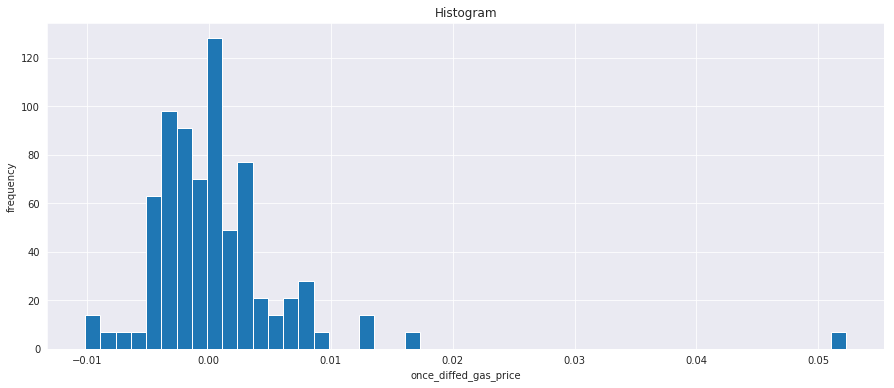

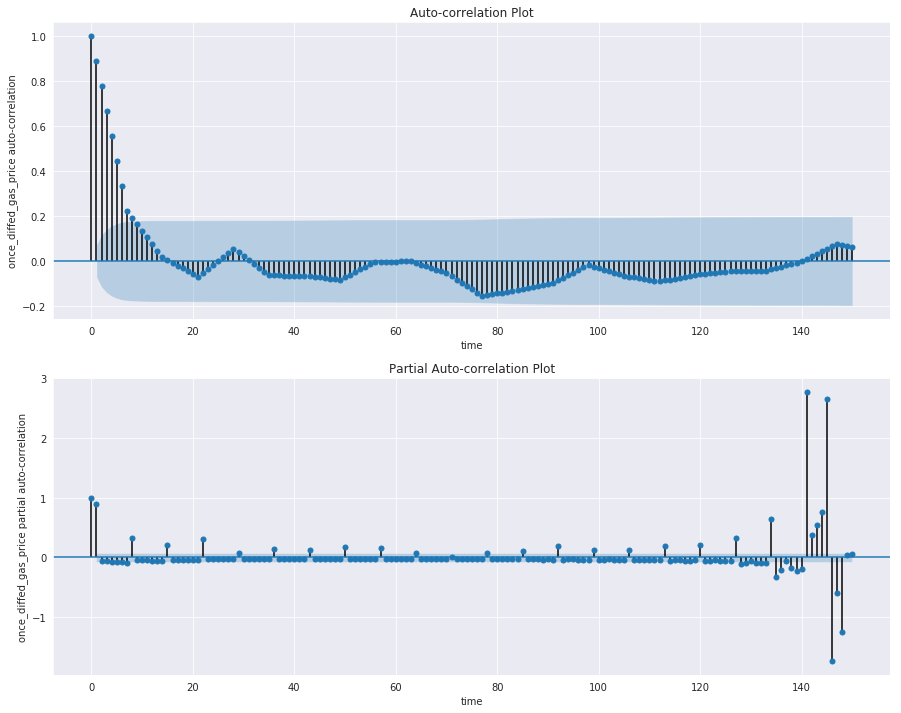

In [213]:
make_ts_plots(series, lag=150, series_name='once_diffed_gas_price')

In [96]:
print('standard deviation of first-order differenced gas price (lag=1) {:f}'.format(std(series)))

standard deviation of first-order differenced gas price (lag=1) 0.006760


#### Analyzing the second-order differenced series (lag=1, 1)

In [97]:
series = drop_inf_na(smooth_diff(drop_inf_na(smooth_diff(df_merged['price'], diff_lag=1)), diff_lag=1))

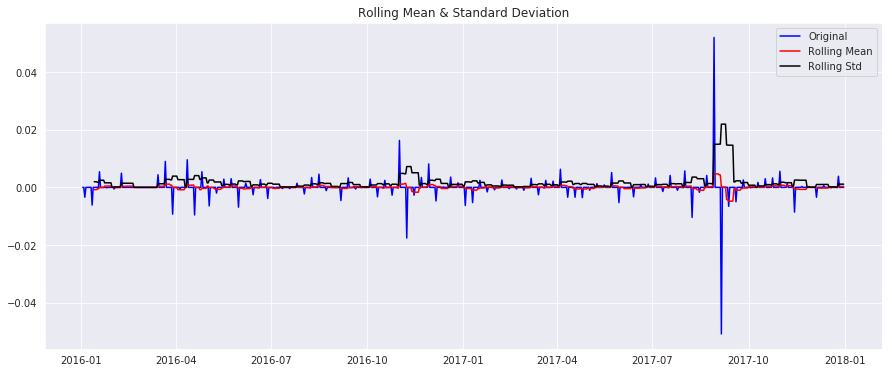

Results of Dickey-Fuller Test:
Test Statistic                -1.013092e+01
p-value                        8.923017e-18
#Lags Used                     2.000000e+01
Number of Observations Used    7.080000e+02
Critical Value (1%)           -3.439620e+00
Critical Value (5%)           -2.865631e+00
Critical Value (10%)          -2.568948e+00
dtype: float64


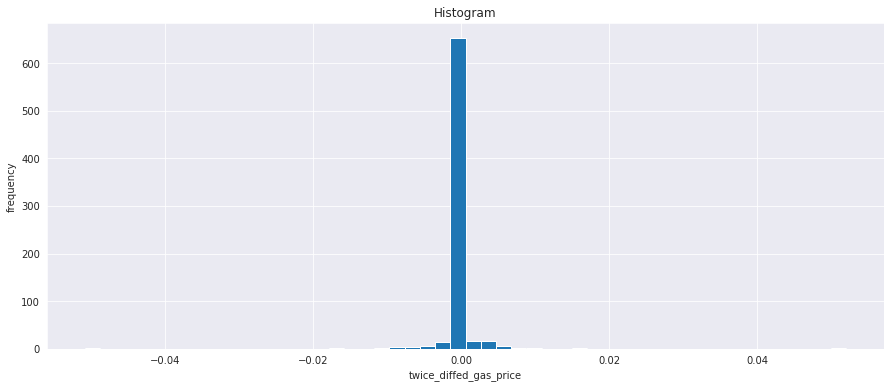

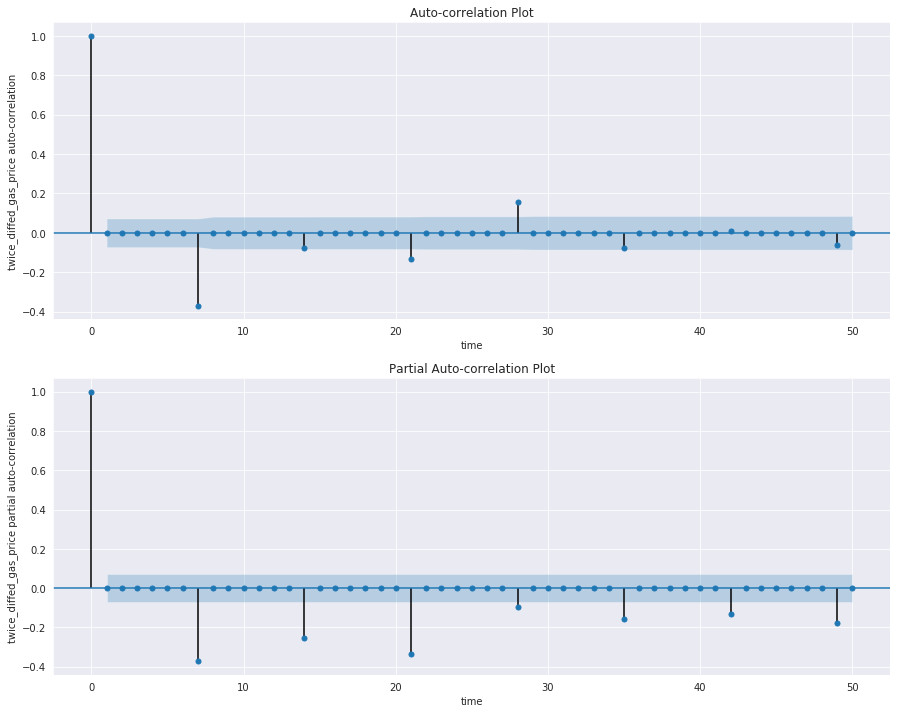

In [98]:
make_ts_plots(series, series_name='twice_diffed_gas_price')

In [99]:
print('standard deviation of second-order differenced gas price (lag=1, 1) {:f}'.format(std(series)))

standard deviation of second-order differenced gas price (lag=1, 1) 0.003190


#### Local Trend

In [100]:
from pyflux import LocalTrend, Normal
def find_local_trend(data, target_col, max_integ=3, family=Normal()):
    aic = []
    loglik = []
    for integ in range(max_integ+1):
        llt_model = LocalTrend(data=data, integ=integ, target=target_col, family=family)
        llt_model_result = llt_model.fit()
        aic.append(llt_model_result.aic)
        loglik.append(llt_model_result.loglik)
    opt_integ = aic.index(min(aic))
    print(aic)
    print(loglik)
    return opt_integ

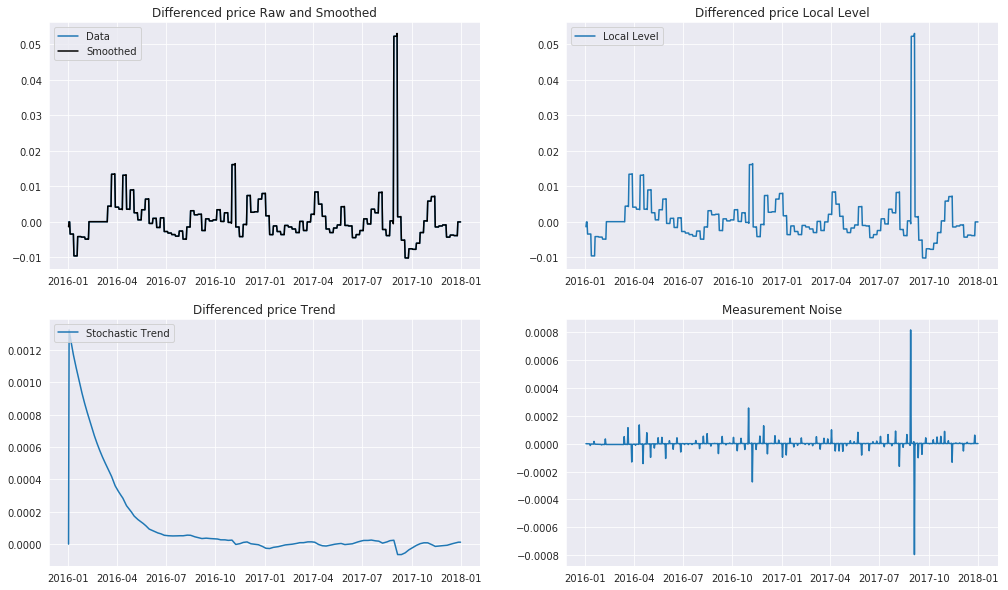

In [101]:
#gas_integ = find_local_trend(data=df_merged, target_col='price', max_integ=3, family=Normal())
gas_llt_model = LocalTrend(data=df_merged, integ=1, target='price', family=Normal())
gas_llt_model_result = gas_llt_model.fit()
gas_llt_model.plot_fit(intervals=False,figsize=(17,10))

In [102]:
gas_llt_model_result.summary()

LLT                                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced price                   Method: MLE                                       
Start Date: 2016-01-01 00:00:00                         Log Likelihood: 3135.8459                         
End Date: 2017-12-31 00:00:00                           AIC: -6265.6917                                   
Number of observations: 730                             BIC: -6251.9126                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Sigma^2 irregular                        4.2e-09                                                          
Sigma^2 level                        

### Weather Temperature

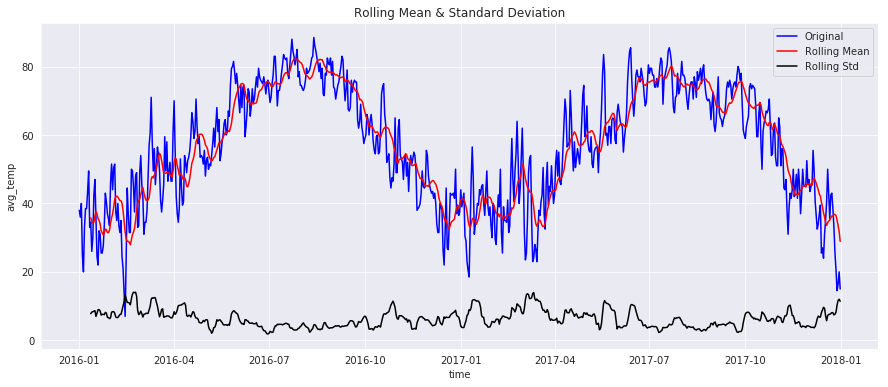

Results of Dickey-Fuller Test:
Test Statistic                  -1.220396
p-value                          0.664761
#Lags Used                      14.000000
Number of Observations Used    716.000000
Critical Value (1%)             -3.439516
Critical Value (5%)             -2.865585
Critical Value (10%)            -2.568924
dtype: float64


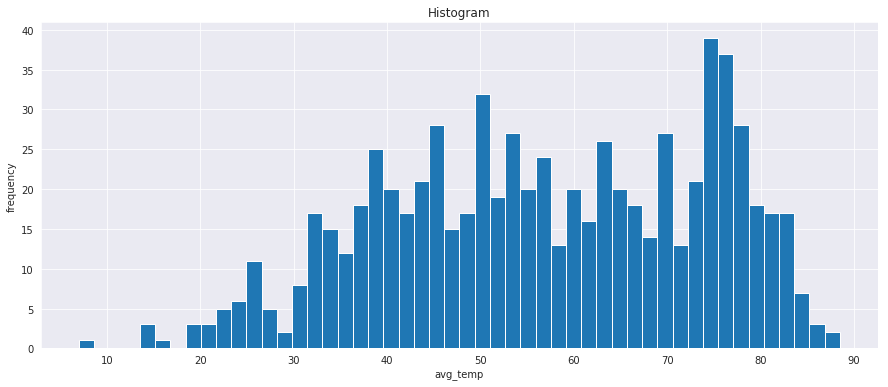

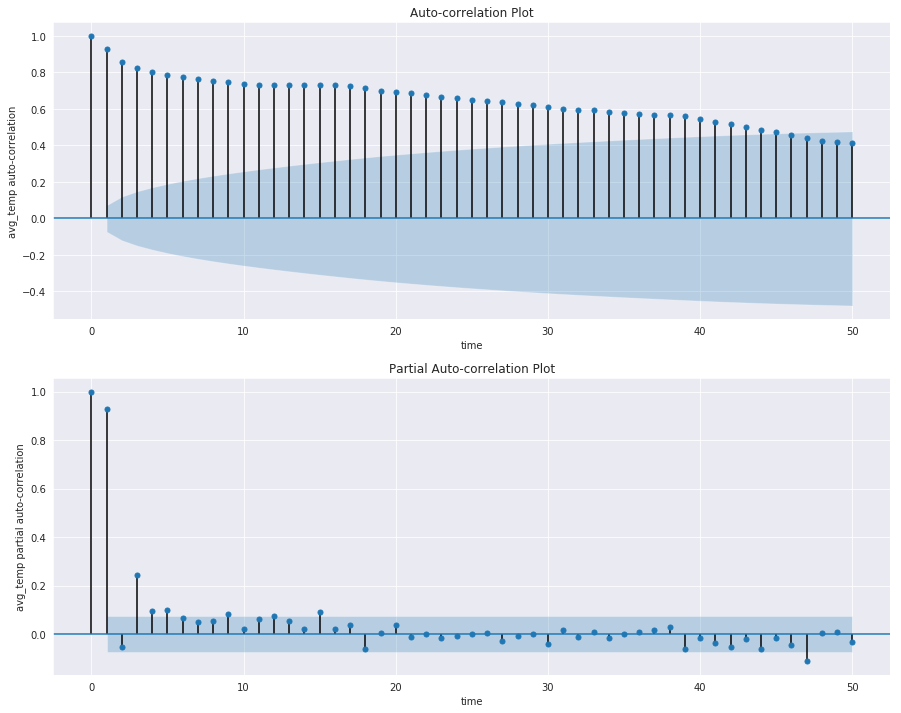

In [211]:
make_ts_plots(df_merged['temp'], lag=50, series_name='avg_temp')

In [104]:
print('standard deviation of un-differenced weather (temperature) {:f}'.format(std(df_merged['temp'])))

standard deviation of un-differenced weather (temperature) 16.979780


#### Analyzing the differenced series (lag=1)

In [105]:
series = drop_inf_na(smooth_diff(df_merged['temp'], diff_lag=1))

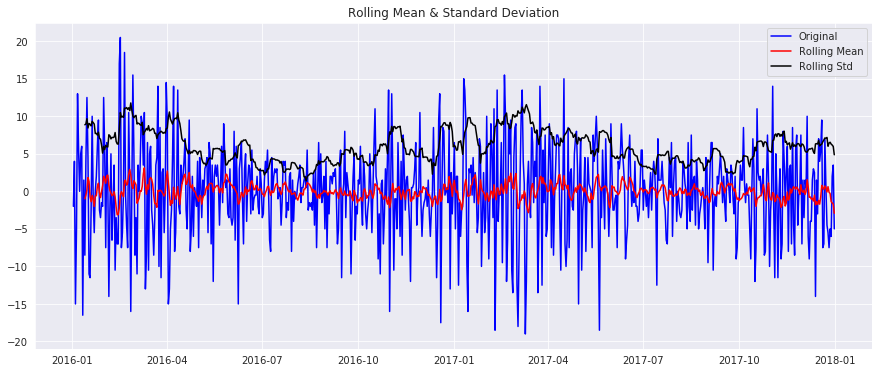

Results of Dickey-Fuller Test:
Test Statistic                -1.081344e+01
p-value                        1.883203e-19
#Lags Used                     1.300000e+01
Number of Observations Used    7.160000e+02
Critical Value (1%)           -3.439516e+00
Critical Value (5%)           -2.865585e+00
Critical Value (10%)          -2.568924e+00
dtype: float64


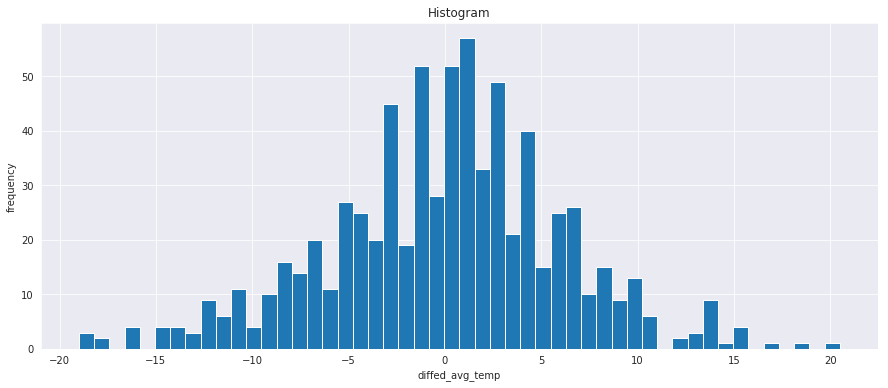

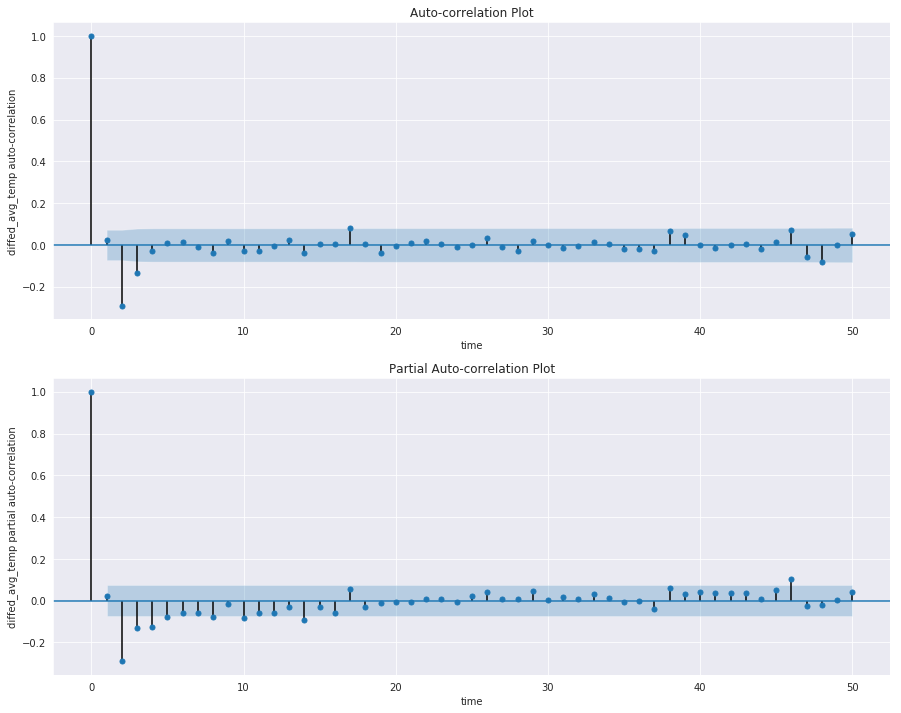

In [106]:
make_ts_plots(series, series_name='diffed_avg_temp')

In [107]:
print('standard deviation of first-order differenced weather (temperature) (lag=1) {:f}'.format(std(series)))

standard deviation of first-order differenced weather (temperature) (lag=1) 6.143966


#### Local Trend

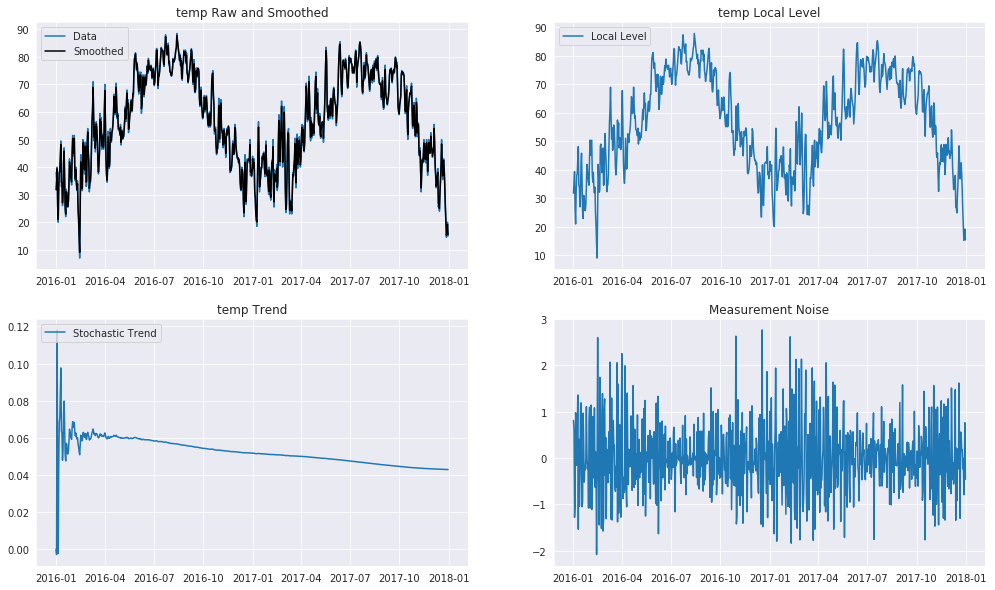

In [108]:
weather_llt_model = LocalTrend(data=df_merged, integ=0, target='temp', family=Normal())
weather_llt_model.fit()
weather_llt_model.plot_fit(intervals=False,figsize=(17,10))

## Transforming the Time Series
#### (using difference with suitable time lag period for each series)

In [109]:
def smooth_log_diff(series, lag=1):
    series = log(series).diff(periods=lag)
    return series

In [110]:
from numpy import polyfit
def smooth_poly(series, degree=2):
    X = [i%365 for i in range(0, len(series))]
    y = series
    coef = polyfit(X, y, degree)
    y_hat = []
    for i in range(len(X)):
        value = coef[-1]
        for d in range(degree):
            value += X[i]**(degree-d) * coef[d]
        y_hat.append(value)
    values = series.values
    diff = []
    for i in range(len(values)):
        value = values[i] - y_hat[i]
        diff.append(value)
    return diff

In [111]:
from scipy.stats import boxcox, boxcox_normmax
import numpy as np 
def smooth_boxcox_diff(series):
    series_min = np.min(series)
    shift = 0.0
    if series_min <= 0:
        shift = - (series_min-1)
        series = series + shift
    lmbda = boxcox_normmax(series.values)
    series = Series(boxcox(series.values, lmbda=lmbda), index=series.index)
    return series, shift, lmbda

In [112]:
def smooth_transform(series, diff_lag=1, boxcox=False):
    if boxcox:
        result = smooth_boxcox_diff(series)
    else:
        result = smooth_diff(series, diff_lag), 0, 0
    return result

### Transit Passengers (exiting the station)
#### no transformation (as this will be handled by the model)

In [113]:
df_t = DataFrame(index=df_merged.index)

In [114]:
df_t['delex'] = df_merged['delex']

### Transit Passengers (entering the station)
#### no transformation (as this will be handled by the model)

In [115]:
df_t['delent'] = df_merged['delent']

### Cab Rides
#### lag = 7, 1

In [116]:
df_t['cabs'] = smooth_diff(df_merged['passengers'], diff_lag=7)
df_t['cabs'] = smooth_diff(df_t['cabs'], diff_lag=1)

### Traffic Speed
#### lag = 1

In [117]:
df_t['traffic'] = smooth_diff(df_merged['speed'], diff_lag=1)

### Gas Price

In [118]:
df_t['gas'] = smooth_diff(df_merged['price'], diff_lag=1)
df_t['gas'] = smooth_diff(df_t['gas'], diff_lag=1)

### Weather Temperature

In [119]:
df_t['weather'] = smooth_diff(df_merged['temp'], diff_lag=1)

## Modeling

### Train-Test Split

In [121]:
def interpolate_inf_na(df):
    df = df.replace([inf, -inf], nan).interpolate('time', limit_direction='both')
    return df    

In [122]:
df_t.loc[df_t.isin([inf,nan]).any(axis=1)]

delex   delent  cabs   traffic           gas  weather
2016-01-01   9225.0  12190.0   NaN       NaN           NaN      NaN
2016-01-02   9084.0  12386.0   NaN -1.718350           NaN     -2.0
2016-01-03   8290.0   9832.0   NaN  0.611350  0.000000e+00      4.0
2016-01-04  21336.0  27878.0   NaN -3.299251  0.000000e+00    -15.0
2016-01-05  24183.0  29831.0   NaN -0.006858 -3.428571e-03     -5.0
2016-01-06  22485.0  30165.0   NaN -0.187286  4.440892e-16     13.0
2016-01-07  21694.0  30568.0   NaN -0.477225 -4.440892e-16      5.5
2016-01-08  22138.0  33550.0   NaN  0.993938  4.440892e-16      0.0

In [123]:
df_t = interpolate_inf_na(df_t)
df_t.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-01-01 to 2017-12-31
Freq: D
Data columns (total 6 columns):
delex      731 non-null float64
delent     731 non-null float64
cabs       731 non-null float64
traffic    731 non-null float64
gas        731 non-null float64
weather    731 non-null float64
dtypes: float64(6)
memory usage: 40.0 KB


In [124]:
train = df_t.loc[:'2017-06-30'][['delex','delent', 'cabs', 'traffic', 'gas', 'weather']]
test = df_t.loc['2017-07-01':][['delex','delent', 'cabs', 'traffic', 'gas', 'weather']]

train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 547 entries, 2016-01-01 to 2017-06-30
Freq: D
Data columns (total 6 columns):
delex      547 non-null float64
delent     547 non-null float64
cabs       547 non-null float64
traffic    547 non-null float64
gas        547 non-null float64
weather    547 non-null float64
dtypes: float64(6)
memory usage: 29.9 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2017-07-01 to 2017-12-31
Freq: D
Data columns (total 6 columns):
delex      184 non-null float64
delent     184 non-null float64
cabs       184 non-null float64
traffic    184 non-null float64
gas        184 non-null float64
weather    184 non-null float64
dtypes: float64(6)
memory usage: 10.1 KB


In [125]:
train_y = train[['delex','delent']]
train_x = train[['cabs', 'traffic', 'gas', 'weather']]
test_y = test[['delex','delent']]
test_x = test[['cabs', 'traffic', 'gas', 'weather']]

### Applying VAR Model

In [137]:
def make_var_plots(var_result, index=0, plot_name='varmax'):
    fig = plt.figure(figsize=(15,12))
    var_result.plot_diagnostics(variable=index, fig=fig)
    fig.savefig(plots_folder+plot_name+'.png')
    return

In [127]:
from statsmodels.tsa.statespace.varmax import VARMAX

### Model Selection

In [128]:
from sklearn.model_selection import TimeSeriesSplit
from numpy import zeros, sum, sqrt, mean
def cv_var(train_x, train_y, target_col):
    p_max = 4
    q_max = 4
    n_splits=5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mean_rmse = zeros((p_max,q_max), dtype=float)
    mean_aic = zeros((p_max,q_max), dtype=float)
    split_idx = 0
    for train_index, test_index in tscv.split(train_x):
        cvtrain_x, cvtest_x = train_x.iloc[train_index], train_x.iloc[test_index]
        cvtrain_y, cvtest_y = train_y.iloc[train_index], train_y.iloc[test_index]

        for p in range(1,p_max+1):
            for q in range(1,q_max+1):
                var_model = VARMAX(cvtrain_y, cvtrain_x, order=(p,q),  enforce_invertibility=True, trend='c', enforce_stationarity=True)
                #try:
                var_model_result = var_model.fit(maxiter=100, disp=False)
                nforecast = len(cvtest_y)
                predict = var_model_result.get_prediction(end=var_model_result.nobs + nforecast-1, exog = cvtest_x)
                y_hat = predict.predicted_mean
                # RSS on validation set
                rmse_i = sqrt(mean((y_hat[[target_col]].values - concat([cvtrain_y, cvtest_y])[[target_col]].values)**2)) 
                #print('order = {:d},{:d}'.format(p,q))
                mean_rmse[p-1,q-1] = mean_rmse[p-1,q-1] + rmse_i
                mean_aic[p-1,q-1] = mean_aic[p-1,q-1] + var_model_result.aic
                #except:
                #    rss[split_idx, p-1,q-1] = nan
                #    aic[split_idx, p-1,q-1] = nan

        split_idx = split_idx + 1
    #print('rss and aic for p_max = {:d}, q_max = {:d}, n_splits = {:d}'.format(p_max, q_max, n_splits))
    #print('rss ',rss)
    #print('aic ',aic)
    mean_rmse = mean_rmse /  n_splits
    mean_aic = mean_aic /  n_splits
    return mean_rmse, mean_aic

In [129]:
rmse_var_delex, aic_var_delex = cv_var(train_x, train_y, target_col='delex')

In [130]:
rmse_var_delent, aic_var_delent = cv_var(train_x, train_y, target_col='delent')

In [131]:
from numpy import unravel_index, argmin
#q = aic.min().idxmin()
#p = aic.idxmin()[q]
print('optimum parameters for delex')
p_var_delex, q_var_delex = unravel_index(argmin(rmse_var_delex, axis=None), rmse_var_delex.shape)
print('optimum order = {:d},{:d} using rmse'.format(p_var_delex, q_var_delex))
p_var_aic_delex, q_var_aic_delex = unravel_index(argmin(aic_var_delex, axis=None), aic_var_delex.shape)
print('optimum order = {:d},{:d} using aic'.format(p_var_aic_delex, q_var_aic_delex))

print('optimum parameters for delent')
p_var_delent, q_var_delent = unravel_index(argmin(rmse_var_delent, axis=None), rmse_var_delent.shape)
print('optimum order = {:d},{:d} using rmse'.format(p_var_delent, q_var_delent))
p_var_aic_delent, q_var_aic_delent = unravel_index(argmin(aic_var_delent, axis=None), aic_var_delent.shape)
print('optimum order = {:d},{:d} using aic'.format(p_var_aic_delent, q_var_aic_delent))

optimum parameters for delex
optimum order = 2,3 using rmse
optimum order = 3,3 using aic
optimum parameters for delent
optimum order = 2,3 using rmse
optimum order = 3,3 using aic


In [132]:
var_model = VARMAX(train_y, train_x, order=(p_var_delex+1, q_var_delex+1),  enforce_invertibility=True, trend='c', enforce_stationarity=True)
var_model_result = var_model.fit(maxiter=5000, disp=False)
print(var_model_result.summary())

                            Statespace Model Results                           
Dep. Variable:     ['delex', 'delent']   No. Observations:                  547
Model:                     VARMAX(3,4)   Log Likelihood              -10193.891
                           + intercept   AIC                          20469.783
Date:                 Mon, 03 Dec 2018   BIC                          20646.265
Time:                         19:00:03   HQIC                         20538.766
Sample:                     01-01-2016                                         
                          - 06-30-2017                                         
Covariance Type:                   opg                                         
Ljung-Box (Q):               623.23, 61.55   Jarque-Bera (JB):        43.62, 215.40
Prob(Q):                        0.00, 0.02   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.45, 0.79   Skew:                     -0.19, -0.60
Prob(H) (two-sided):        

### Heteroskedasticity
#### (null hypothesis - no heteroskedasticity, variance not changing throughout sample)

In [133]:
h_test = var_model_result.test_heteroskedasticity(method=None)
print('Transit Passengers (exiting the station) :')
print('t-statistic ', h_test[0][0])
print('p-value     ', h_test[0][1])
print('')
print('Transit Passengers (entering the station) :')
print('t-statistic ', h_test[1][0])
print('p-value     ', h_test[1][1])

Transit Passengers (exiting the station) :
t-statistic  1.4471757664411473
p-value      0.013037722320413319

Transit Passengers (entering the station) :
t-statistic  0.794863263031284
p-value      0.1223898072811961


### Transit Passengers (exiting the station)

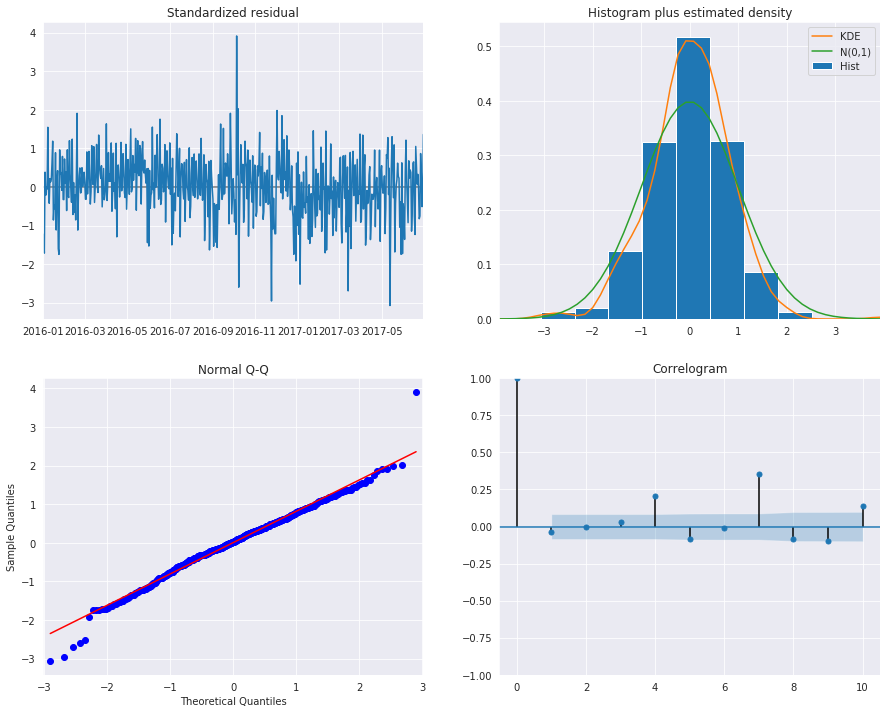

In [138]:
make_var_plots(var_model_result, index=0, plot_name='transit_exits_varmax')

### Transit Passengers (entering the station)

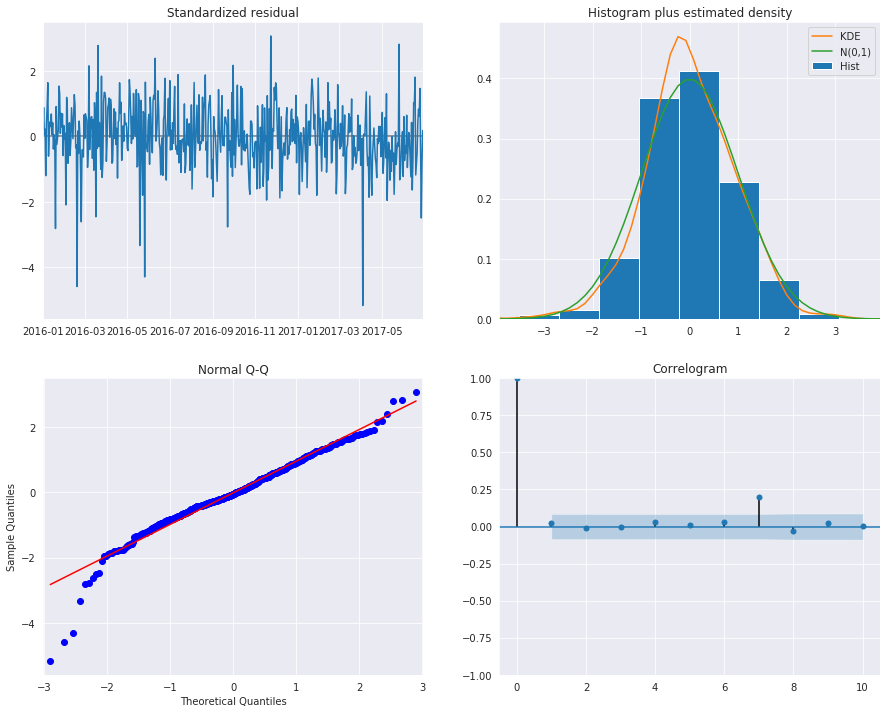

In [139]:
make_var_plots(var_model_result, index=1, plot_name='transit_entries_varmax')

### Forecasting

In [140]:
# Generate Exogenous Data for Forecasting
nforecast = len(test_x)
print('no. of training observations ',var_model_result.nobs)
print('no. of data-points to be forecast ',nforecast)

no. of training observations  547
no. of data-points to be forecast  184


In [141]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
predict = var_model_result.get_prediction(end=var_model_result.nobs + nforecast-1, exog = test_x)
forecast = var_model_result.get_forecast(nforecast, exog = test_x)
""" idx = np.arange(len(predict.predicted_mean)) """
predict_ci95 = predict.conf_int(alpha=0.05)
predict_ci60 = predict.conf_int(alpha=0.4)
predict_ci30 = predict.conf_int(alpha=0.7)

In [142]:
pred_mean = predict.predicted_mean
forcast_results = forecast.prediction_results

### Inverse Transformation

#### Inverse Transform for single diff

$$\dot y_t = y_t - y_{t-lag}$$

$$y_t = \dot y_t + y_{t-lag}$$

In [285]:
# inverse diff
def inverse_diff(y_hat_trnsfmd, y_init, diff_lag):
    df = DataFrame(y_hat_trnsfmd.values, columns=['y_hat_trnsfmd'])
    init_len = diff_lag
    df = df.iloc[init_len:]
    df_init = DataFrame(y_init.values, columns=['y_hat_trnsfmd'])
    df = concat([df_init, df])
    df['y_hat'] = df['y_hat_trnsfmd']
    for idx in df.index:
        if idx >= diff_lag:
            df['y_hat'].iloc[idx] = df['y_hat_trnsfmd'].iloc[idx] + df['y_hat'].iloc[idx-diff_lag]
    df.index = y_hat_trnsfmd.index
    return df['y_hat']

#### Inverse Transform for double diff

$$\dot y_t = y_t - y_{t-lag1}$$
$$\ddot y_t = \dot y_t - \dot y_{t-lag2}$$

$$y_t = \dot y_t + y_{t-lag1}
      = \ddot y_t + \dot y_{t-lag2} + y_{t-lag1}
      = \ddot y_t + y_{t-lag1} + y_{t-lag2} - y_{t-lag2-lag1}$$

In [286]:
# inverse double diff
def inverse_dbl_diff(y_hat_trnsfmd, y_init, diff_lag1, diff_lag2):
    df = DataFrame(y_hat_trnsfmd.values, columns=['y_hat_trnsfmd'])
    init_len = diff_lag1+diff_lag2
    df = df.iloc[init_len:]
    df_init = DataFrame(y_init.values, columns=['y_hat_trnsfmd'])
    df = concat([df_init, df])
    df['y_hat'] = df['y_hat_trnsfmd']
    for idx in df.index:
        if idx >= (diff_lag1+diff_lag2):
            df['y_hat'].iloc[idx] = df['y_hat_trnsfmd'].iloc[idx] + df['y_hat'].iloc[idx-diff_lag1] + df['y_hat'].iloc[idx-diff_lag2] - df['y_hat'].iloc[idx-diff_lag2-diff_lag1]
    df.index = y_hat_trnsfmd.index
    return df['y_hat']

##### The below inverse transform is not needed for VARMAX output as the model handles transformation

In [327]:
#from pandas import Timedelta
#from numpy import full, mean
#y_cols = ['delex','delent']
#lag1=7
##lag2=1
#idx0 = df_merged.index.to_series().iloc[0]
#pred_mean_inv = DataFrame(index=pred_mean.index, columns=y_cols)
##td = Timedelta(lag1+lag2-1, unit='d')
#td = Timedelta(lag1-1, unit='d')
#initial_idx = (idx0+td).strftime('%Y-%m-%d')
#for col in y_cols:
#    init_values = Series(full((lag1,),mean(df_merged[col].values)), dtype=float, index=df_merged[col].loc[:initial_idx].index)
#    print(init_values.head())
#    #pred_mean_inv[col] = inverse_dbl_diff(pred_mean[col], df_merged[col].loc[:initial_idx], diff_lag1=lag1, diff_lag2=lag2) 
#    pred_mean_inv[col] = inverse_diff(pred_mean[col], init_values, diff_lag=lag1) 
#pred_mean_inv.info()

In [144]:
def make_prediction_plot(df, train_y, test_y, predict, y_column, days_to_skip=1, plot_improved=False, 
                         model_resid=None, plot_name=''):    
    td_skip = Timedelta(days_to_skip-1, unit='d')
    idx0 = df.index.to_series().iloc[0] + td_skip
    start_idx = idx0.strftime('%Y-%m-%d')
    if idx0 > train_y.index.to_series().iloc[len(train_y)-1]:
        train_y = DataFrame()
        test_y = test_y.loc[start_idx:]
    else:
        train_y = train_y.loc[start_idx:]
        
    
    train_y = df.loc[train_y.index][[y_column]]
    test_y = df.loc[test_y.index][[y_column]]
    nforecast = len(test_y)
    df = concat([train_y, test_y])
    idx = df.index
    # Graph
    fig, ax = plt.subplots(figsize=(18,10))
    ax.grid()
    ax.plot(idx,df,'k',label='', alpha=1, linewidth=0.75)
    ax.plot(idx,df,'k.', label='Actual Values', alpha=1, linewidth=0.75)
    
    pred_mean=predict.predicted_mean.loc[start_idx:][[y_column]]
    if plot_improved and model_resid is not None:
        print('plotting improved predictions')
        pred_mean, _ = improve_model_predictions(pred_mean, model_resid, nforecast)
    lag1=7
    #lag2=1
    #td = Timedelta(lag1+lag2-1, unit='d')
    td = Timedelta(lag1-1, unit='d')
    initial_idx = (idx0+td).strftime('%Y-%m-%d')
    offset=0
    predict_ci95 = predict.conf_int(alpha=0.05).loc[start_idx:]
    predict_ci60 = predict.conf_int(alpha=0.4).loc[start_idx:]
    predict_ci30 = predict.conf_int(alpha=0.7).loc[start_idx:]
    lower = 'lower '+y_column
    upper = 'upper '+y_column
    predict_ci95_lower = predict_ci95[lower] + offset
    predict_ci60_lower = predict_ci60[lower] + offset
    predict_ci30_lower = predict_ci30[lower] + offset
    predict_ci95_upper = predict_ci95[upper] + offset
    predict_ci60_upper = predict_ci60[upper] + offset
    predict_ci30_upper = predict_ci30[upper] + offset
    
    # Plot
    if len(train_y) > 0:
        ax.plot(train_y.index, pred_mean[:-nforecast], color='blue',alpha=0.7, label='Train-Set Prediction')
    ax.plot(test_y.index, pred_mean[-nforecast:], 'k--', color='red', alpha=0.7, linestyle='--', linewidth=1.5,label='Test-Set Prediction')
    
   
    #if inverse_trans_func is None:
    ax.fill_between(test_y.index, predict_ci95_lower.iloc[-nforecast:], 
                    predict_ci95_upper.iloc[-nforecast:], alpha=0.15, label= '')
    ax.fill_between(test_y.index, predict_ci60_lower.iloc[-nforecast:], 
                    predict_ci60_upper.iloc[-nforecast:], alpha=0.15, label= '')
    ax.fill_between(test_y.index, predict_ci30_lower.iloc[-nforecast:], 
                    predict_ci30_upper.iloc[-nforecast:], alpha=0.15, label= '')
    ax.legend()
    ax.set(title='VARMAX - Forecasting for '+plot_name+' beginning '+start_idx)
    ax.set_xlabel('time')
    ax.set_ylabel(plot_name)
    plt.show(fig)
    fig.savefig(plots_folder+'varmax_pred_'+plot_name+'.png')

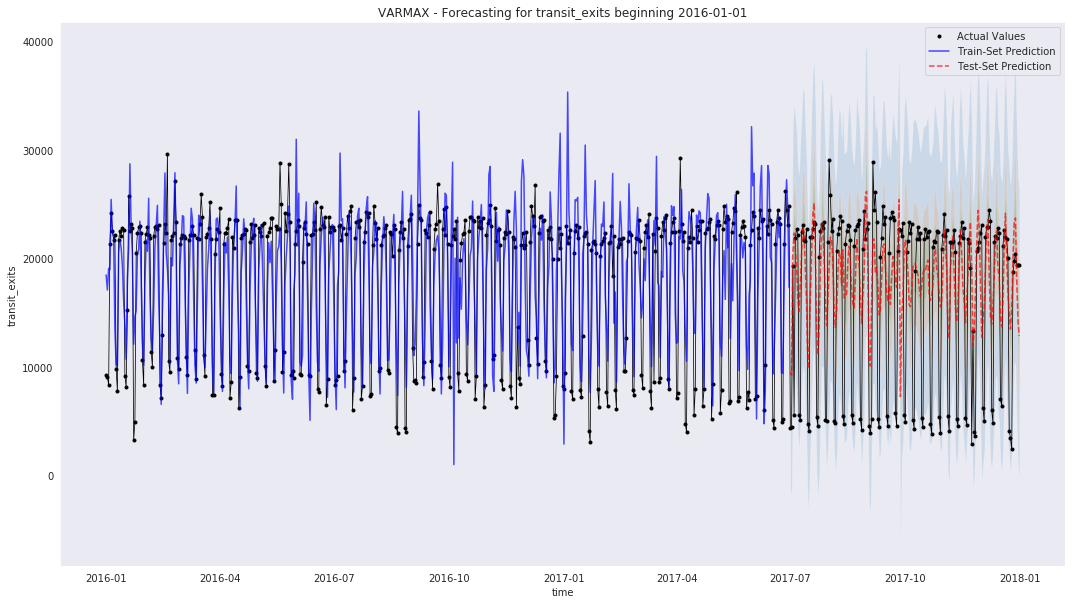

In [145]:
make_prediction_plot(df_merged, train_y, test_y, predict, 'delex', plot_name='transit_exits')

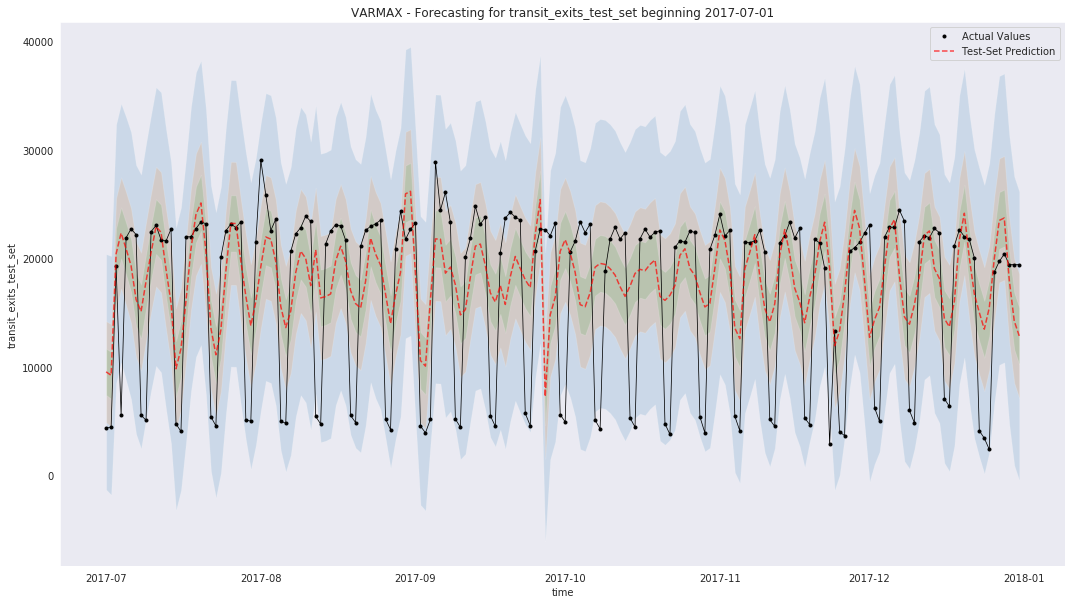

In [146]:
make_prediction_plot(df_merged, train_y, test_y, predict, 'delex', days_to_skip=548, plot_name='transit_exits_test_set')

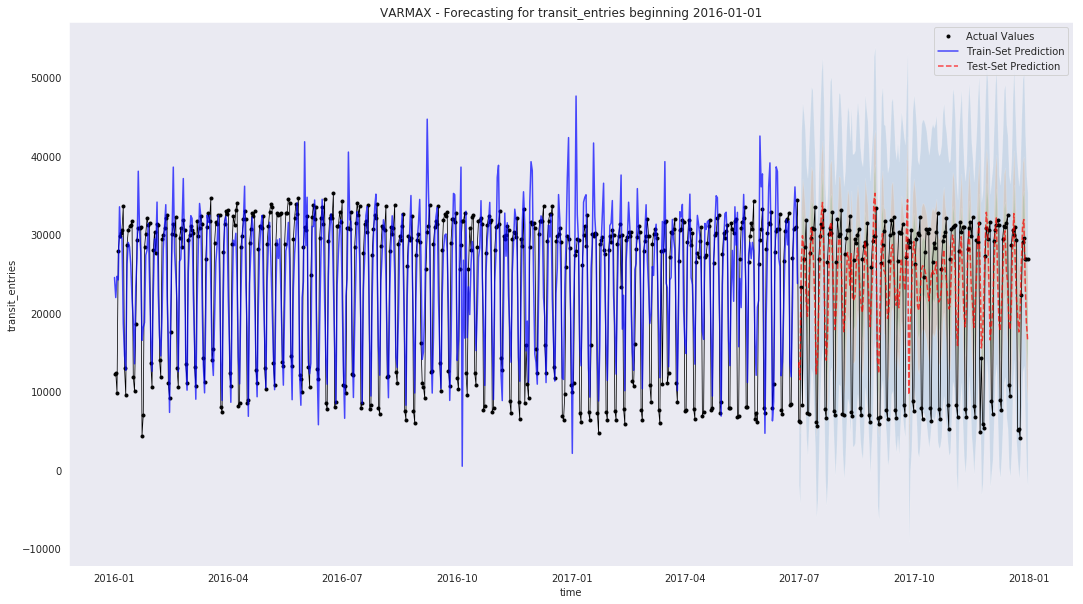

In [147]:
make_prediction_plot(df_merged, train_y, test_y, predict, 'delent', plot_name='transit_entries')

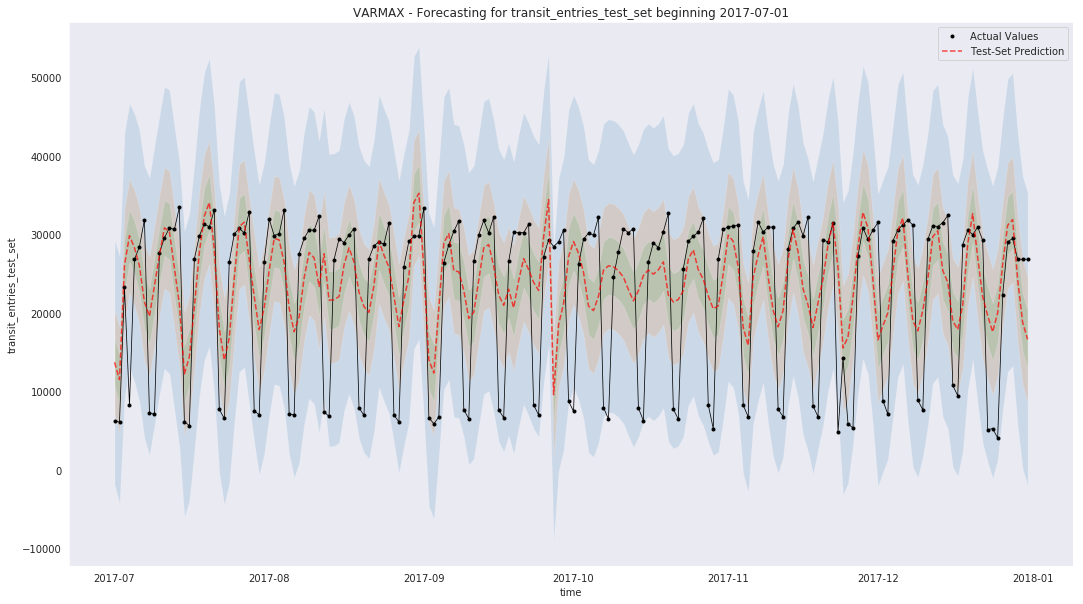

In [148]:
make_prediction_plot(df_merged, train_y, test_y, predict, 'delent', days_to_skip=548, plot_name='transit_entries_test_set')

### Fitting an AR model to the VARMAX residuals

In [149]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA

In [150]:
from sklearn.model_selection import TimeSeriesSplit
from numpy import zeros, sum, sqrt, mean
def cv_arma(train_x, train_y, target_col):
    p_max = 4
    q_max = 4
    n_splits=5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mean_rmse = zeros((p_max,q_max), dtype=float)
    mean_aic = zeros((p_max,q_max), dtype=float)
    split_idx = 0
    for train_index, test_index in tscv.split(train_x):
        cvtrain_x, cvtest_x = train_x.iloc[train_index], train_x.iloc[test_index]
        cvtrain_y, cvtest_y = train_y.iloc[train_index][[target_col]], train_y.iloc[test_index][[target_col]]

        for p in range(1,p_max+1):
            for q in range(1,q_max+1):
                arma_model = ARMA(cvtrain_y, exog=cvtrain_x, order=(p,q))
                #try:
                arma_model_result = arma_model.fit(maxiter=100, disp=False)
                nforecast = len(cvtest_y)
                y_hat = arma_model_result.predict(end=arma_model_result.nobs + nforecast-1, exog = cvtest_x)
                # RSS on validation set
                rmse_i = sqrt(mean((y_hat.values - concat([cvtrain_y, cvtest_y]).values)**2)) 
                #print('order = {:d},{:d}'.format(p,q))
                mean_rmse[p-1,q-1] = mean_rmse[p-1,q-1] + rmse_i
                mean_aic[p-1,q-1] = mean_aic[p-1,q-1] + arma_model_result.aic

        split_idx = split_idx + 1
    mean_rmse = mean_rmse /  n_splits
    mean_aic = mean_aic /  n_splits
    return mean_rmse, mean_aic

In [151]:
def improve_model_predictions(model_predictions, model_residuals, nforecast):
    improved_predictions = DataFrame(index=model_predictions.index, columns=model_predictions.columns, dtype=float)
    predicted_resid = DataFrame(index=model_predictions.index.to_series().iloc[-nforecast:],columns=model_predictions.columns, dtype=float)
    for col in model_predictions.columns:
        resid_ar_model = AR(model_residuals[col])
        resid_ar_model_result = resid_ar_model.fit(ic='aic', transparams=True, maxiter=1000, method='mle')
        predicted_resid[col] = resid_ar_model_result.predict(start=resid_ar_model_result.nobs, end=resid_ar_model_result.nobs + nforecast-1)
        
        improved_predictions.iloc[:-nforecast][col] = model_predictions.iloc[:-nforecast][col]
        improved_predictions.iloc[-nforecast:][col] = model_predictions.iloc[-nforecast:][col] + predicted_resid[col]
    return improved_predictions, predicted_resid

In [152]:
improved_pred_mean, predicted_resid = improve_model_predictions(pred_mean, var_model_result.resid, nforecast)

In [153]:
improved_pred_mean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-01-01 to 2017-12-31
Freq: D
Data columns (total 2 columns):
delex     731 non-null float64
delent    731 non-null float64
dtypes: float64(2)
memory usage: 37.1 KB


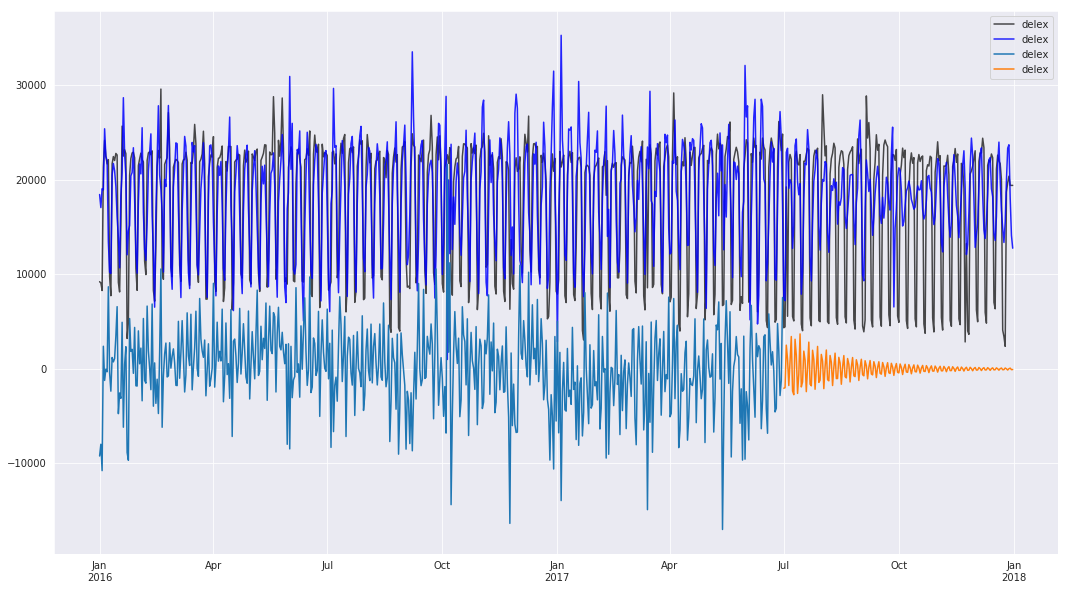

In [154]:
fig, ax = plt.subplots(figsize=(18,10))
df_t[['delex']].plot(ax=ax, color='black', alpha=.7, label='Actual')
improved_pred_mean[['delex']].plot(ax=ax, color='blue', alpha=0.85, label='Predicted')
var_model_result.resid[['delex']].plot(ax=ax)
predicted_resid[['delex']].plot(ax=ax)

plotting improved predictions


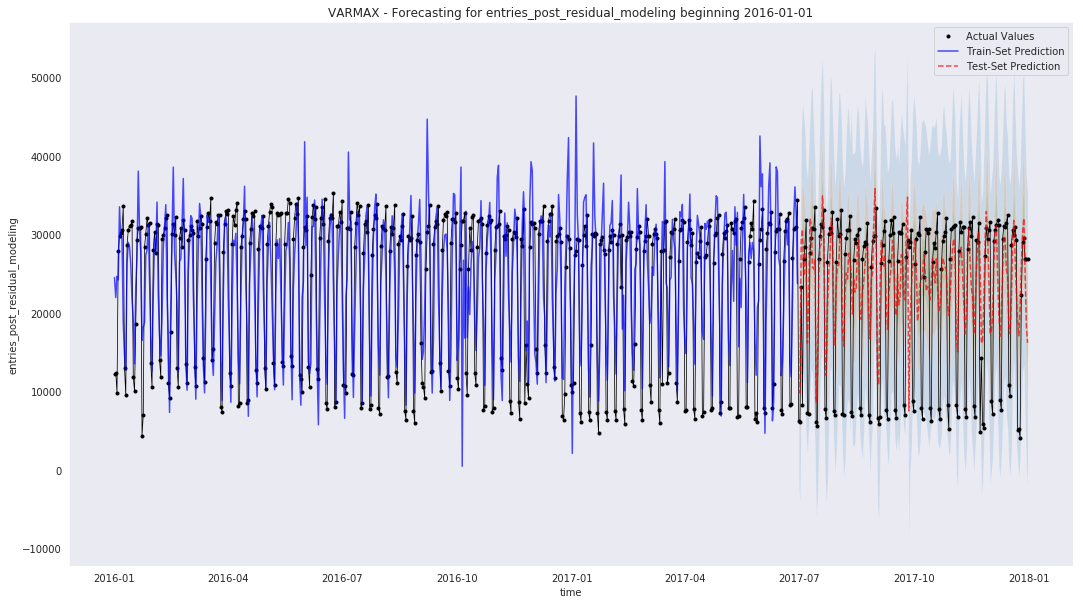

In [157]:
make_prediction_plot(df_merged, train_y, test_y, predict, 'delent',  plot_improved=True, 
                     model_resid=var_model_result.resid, plot_name='entries_post_residual_modeling')

plotting improved predictions


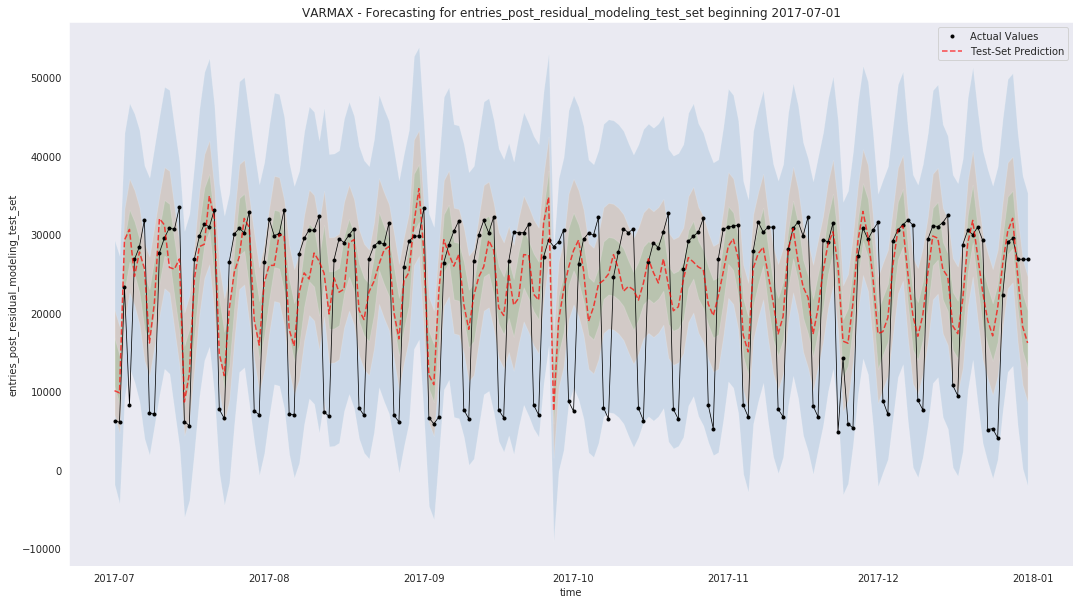

In [158]:
make_prediction_plot(df_merged, train_y, test_y, predict, 'delent',  days_to_skip=548, plot_improved=True, 
                     model_resid=var_model_result.resid, plot_name='entries_post_residual_modeling_test_set')

### Model Accuracy

In [159]:
from sklearn.metrics import mean_squared_error, r2_score
from numpy import sqrt

def accuracy_score(y, y_hat, method='mse'):
    if method == 'r2':
        return r2_score(y, y_hat)
    elif method == 'rmse':
        return sqrt(mean_squared_error(y, y_hat))
    else:
        return mean_squared_error(y, y_hat)        

In [160]:
y = test_y['delex']
y_hat = improved_pred_mean[-nforecast:]['delex']
print('accuracy score for VARMAX predicting transit exits is {:f}'.format(accuracy_score(y, y_hat, 'rmse')))

accuracy score for VARMAX predicting transit exits is 6773.597199


In [161]:
y = test_y['delent']
y_hat = pred_mean[-nforecast:]['delent']
print('accuracy score for VARMAX predicting transit entries is {:f}'.format(accuracy_score(y, y_hat, 'rmse')))

accuracy score for VARMAX predicting transit entries is 9039.962297


In [162]:
y_hat = improved_pred_mean[-nforecast:]['delent']
print('accuracy score for VARMAX+ARMA predicting transit entries is {:f}'.format(accuracy_score(y, y_hat, 'rmse')))

accuracy score for VARMAX+ARMA predicting transit entries is 8309.920814


### Fitting a VECM Model

In [163]:
from sklearn.model_selection import TimeSeriesSplit
from numpy import zeros, sum, sqrt, mean
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
from statsmodels.tsa.vector_ar.vecm import VECM
def cv_vecm(train_x, train_y, target_col):
    k_max = 4
    c_max = 4
    n_splits=5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mean_rmse = zeros((k_max,c_max), dtype=float)
    mean_ll = zeros((k_max,c_max), dtype=float)
    split_idx = 0
    target_col_idx = list(train_y.columns).index(target_col)
    for train_index, test_index in tscv.split(train_x):
        cvtrain_x, cvtest_x = train_x.iloc[train_index], train_x.iloc[test_index]
        cvtrain_y, cvtest_y = train_y.iloc[train_index], train_y.iloc[test_index]

        for k in range(1,k_max+1):
            for c in range(1,c_max+1):
                vecm_model = VECM(endog=cvtrain_y, exog=cvtrain_x, k_ar_diff  = k, coint_rank = c, seasons=7, first_season=1)
                vecm_model_result = vecm_model.fit()
                nforecast = len(cvtest_y)
                y_hat = vecm_model_result.predict(steps=nforecast, exog_fc = cvtest_x)
                #y_hat = predict.predicted_mean
                # RSS on validation set
                #rmse_i = sqrt(mean((y_hat - concat([cvtrain_y, cvtest_y])[[target_col]].values)**2)) 
                rmse_i = sqrt(mean((y_hat[:,target_col_idx] - cvtest_y[[target_col]].values)**2)) 
                #print('order = {:d},{:d}'.format(p,q))
                mean_rmse[k-1,c-1] = mean_rmse[k-1,c-1] + rmse_i
                mean_ll[k-1,c-1] = mean_ll[k-1,c-1] + vecm_model_result.llf

        split_idx = split_idx + 1
    mean_rmse = mean_rmse /  n_splits
    mean_ll = mean_ll /  n_splits
    return mean_rmse, mean_ll

In [164]:
rmse_vecm_delex, ll_vecm_delex = cv_vecm(train_x, train_y, target_col='delex')

In [165]:
rmse_vecm_delent, ll_vecm_delent = cv_vecm(train_x, train_y, target_col='delent')

In [166]:
from numpy import unravel_index, argmin, argmax
print('optimum parameters for delex')
k_vecm_delex, c_vecm_delex = unravel_index(argmin(rmse_vecm_delex, axis=None), rmse_vecm_delex.shape)
print('optimum params = {:d},{:d} using rmse'.format(k_vecm_delex,c_vecm_delex))
k_vecm_ll_delex, c_vecm_ll_delex = unravel_index(argmax(ll_vecm_delex, axis=None), ll_vecm_delex.shape)
print('optimum params = {:d},{:d} using log lokelihood'.format(k_vecm_ll_delex, c_vecm_ll_delex))

print('optimum parameters for delent')
k_vecm_delent, c_vecm_delent = unravel_index(argmin(rmse_vecm_delent, axis=None), rmse_vecm_delent.shape)
print('optimum params = {:d},{:d} using rmse'.format(k_vecm_delent, c_vecm_delent))
k_vecm_ll_delent, c_vecm_ll_delent = unravel_index(argmax(ll_vecm_delent, axis=None), ll_vecm_delent.shape)
print('optimum params = {:d},{:d} using log lokelihood'.format(k_vecm_ll_delent, c_vecm_ll_delent))

optimum parameters for delex
optimum params = 2,0 using rmse
optimum params = 3,1 using log lokelihood
optimum parameters for delent
optimum params = 2,1 using rmse
optimum params = 3,1 using log lokelihood


In [167]:
vecm_model = VECM(endog=train_y, exog=train_x, k_ar_diff  = k_vecm_ll_delex+1, coint_rank = c_vecm_ll_delex+1, seasons=7, first_season=1)
vecm_model_result = vecm_model.fit()
y_hat = vecm_model_result.predict(steps=nforecast, exog_fc = test_x)
print(vecm_model_result.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation delex
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
season1     -235.2930    961.023     -0.245      0.807   -2118.864    1648.278
season2    -2204.1968   1171.799     -1.881      0.060   -4500.880      92.487
season3    -1.917e+04    880.511    -21.768      0.000   -2.09e+04   -1.74e+04
season4    -1.401e+04   1215.822    -11.522      0.000   -1.64e+04   -1.16e+04
season5     -838.8635   1358.107     -0.618      0.537   -3500.703    1822.976
season6     -504.3647    996.378     -0.506      0.613   -2457.231    1448.501
exog1        141.0227     18.263      7.722      0.000     105.227     176.818
exog2        -61.7266     24.917     -2.477      0.013    -110.562     -12.891
exog3       2.216e+04   5.61e+04      0.395      0.693   -8.78e+04    1.32e+05
exog4         25.3131     15.593      1.623   

In [185]:
def make_vecm_prediction_plot(df, train_y, test_x, test_y, vecm_model_result, y_column, 
                              days_to_skip=1, plot_improved=False, plot_name=''):    
    idx0 = df.index.to_series().iloc[0]
    start_idx = idx0.strftime('%Y-%m-%d')
    if idx0 > train_y.index.to_series().iloc[len(train_y)-1]:
        train_y = DataFrame()
        test_y = test_y.loc[start_idx:]
    else:
        train_y = train_y.loc[start_idx:]
        
    
    train_y = df.loc[train_y.index][[y_column]]
    test_y = df.loc[test_y.index][[y_column]]
    nforecast = len(test_y)
    
    #pred_mean=predict.predicted_mean.loc[start_idx:][[y_column]]
    k_ar = vecm_model_result.k_ar
    td = Timedelta(k_ar, unit='d')
    initial_idx = (idx0+td).strftime('%Y-%m-%d')
    y_hat = vecm_model_result.predict(steps=nforecast, exog_fc = test_x)
    vecm_y_hat = DataFrame(index=test_y.index, columns=[y_column], dtype=float)
    vecm_y_hat[y_column] = y_hat[:,0]
    y_hat_train = vecm_model_result.fittedvalues
    vecm_y_hat_train = DataFrame(index=train_y.loc[initial_idx:].index, columns=[y_column], dtype=float)
    vecm_y_hat_train[y_column] = y_hat_train[:,0]
    if plot_improved:
        print('plotting improved predictions')
        vecm_resid = DataFrame(index=train_y[initial_idx:].index, columns=[y_column], dtype=float)
        vecm_resid[y_column] = vecm_model_result.resid[:,0]
        vecm_y_hat, pred_resid = improve_model_predictions(vecm_y_hat, vecm_resid, nforecast)
    
    # Plot    
    td_skip = Timedelta(days_to_skip-1, unit='d')
    start_idx = (idx0+td+td_skip).strftime('%Y-%m-%d')
    if idx0 > train_y.index.to_series().iloc[len(train_y)-1]:
        train_y = DataFrame()
        test_y = test_y.loc[start_idx:]
        vecm_y_hat = vecm_y_hat.loc[start_idx:]
    else:
        train_y = train_y.loc[start_idx:]
        vecm_y_hat_train = vecm_y_hat_train.loc[start_idx:]
        
    df = concat([train_y, test_y])
    idx = df.index
    # Graph
    fig, ax = plt.subplots(figsize=(18,10))
    ax.grid()
    ax.plot(idx,df,'k',label='', alpha=1, linewidth=0.75)
    ax.plot(idx,df,'k.', label='Actual Values', alpha=1, linewidth=0.75)
    
    if len(train_y) > 0:
        ax.plot(train_y.index, vecm_y_hat_train[y_column], color='blue',alpha=0.7, label='Train-Set Prediction')
    ax.plot(test_y.index, vecm_y_hat[y_column], 'k--', color='red', alpha=0.7, linestyle='--', linewidth=1.5,label='Test-Set Prediction')
   
    ax.legend()
    ax.set(title='VECM - Forecasting for '+plot_name+' beginning '+start_idx);
    ax.set_xlabel('time')
    ax.set_ylabel(plot_name)
    plt.show(fig)
    fig.savefig(plots_folder+'vecm_pred_'+plot_name+'.png')

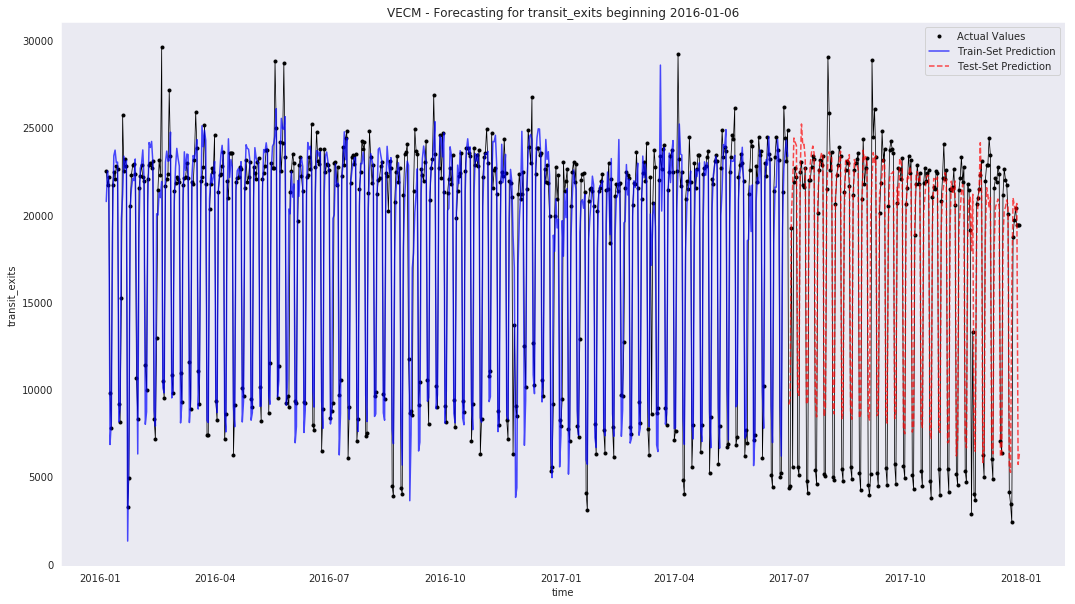

In [186]:
make_vecm_prediction_plot(df_merged, train_y, test_x, test_y, vecm_model_result, 'delex', 
                          plot_name='transit_exits')

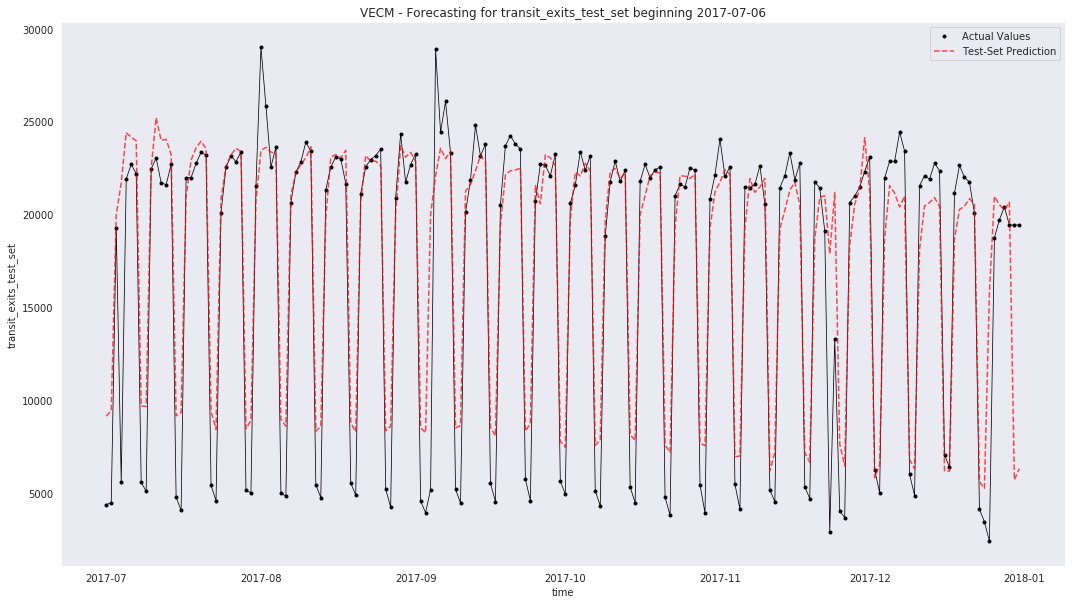

In [187]:
make_vecm_prediction_plot(df_merged, train_y, test_x, test_y, vecm_model_result, 'delex', days_to_skip=548, 
                          plot_name='transit_exits_test_set')

In [188]:
vecm_model_2 = VECM(endog=train_y, exog=train_x, k_ar_diff  = k_vecm_delent+1, coint_rank = c_vecm_delent+1, seasons=7, first_season=1)
vecm_model_result_2 = vecm_model_2.fit()
y_hat_2 = vecm_model_result_2.predict(steps=nforecast, exog_fc = test_x)
print(vecm_model_result_2.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation delex
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
season1    -3386.3985    634.524     -5.337      0.000   -4630.042   -2142.755
season2    -6085.5724    672.047     -9.055      0.000   -7402.760   -4768.385
season3    -2.118e+04    720.568    -29.391      0.000   -2.26e+04   -1.98e+04
season4    -1.489e+04   1196.908    -12.438      0.000   -1.72e+04   -1.25e+04
season5    -1024.4502   1368.784     -0.748      0.454   -3707.217    1658.317
season6     -580.6310    976.861     -0.594      0.552   -2495.243    1333.981
exog1        146.4012     18.450      7.935      0.000     110.240     182.562
exog2        -65.1407     25.264     -2.578      0.010    -114.657     -15.624
exog3      -2423.0263   5.67e+04     -0.043      0.966   -1.14e+05    1.09e+05
exog4         23.1440     15.866      1.459   

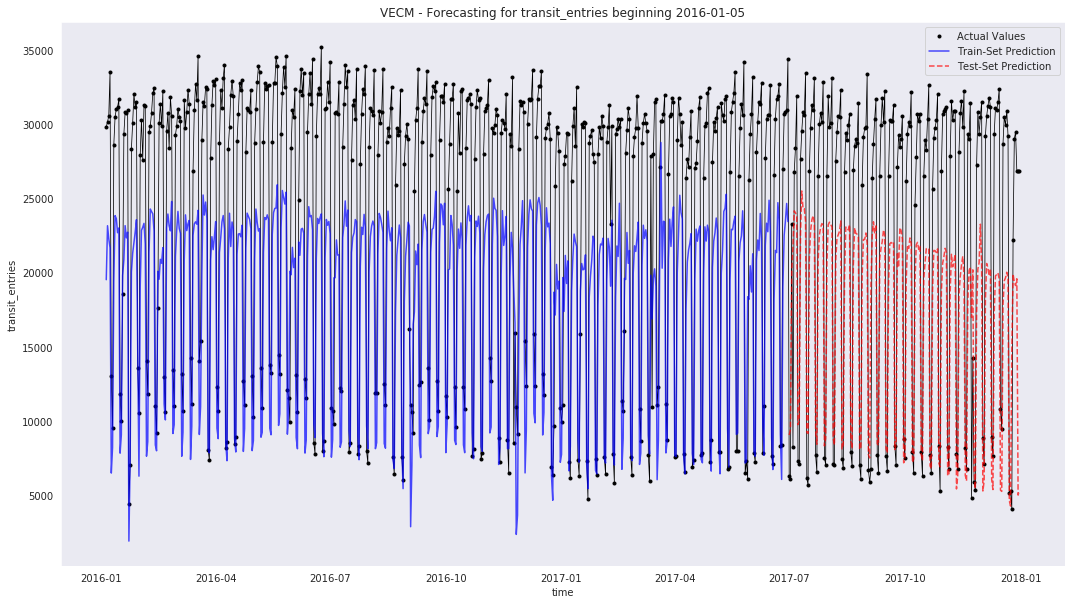

In [189]:
make_vecm_prediction_plot(df_merged, train_y, test_x, test_y, vecm_model_result_2, 'delent', 
                          plot_name='transit_entries')

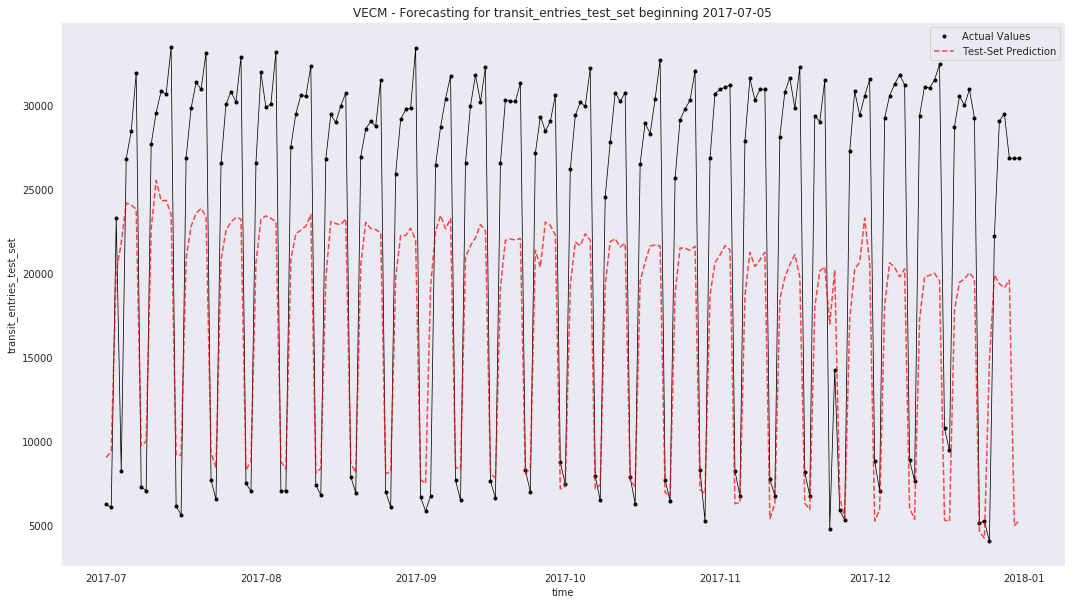

In [190]:
make_vecm_prediction_plot(df_merged, train_y, test_x, test_y, vecm_model_result_2, 'delent', days_to_skip=548, 
                          plot_name='transit_entries_test_set')

### Modeling the residuals to improve VECM predictions

In [200]:
vecm_resid_res = vecm_model_result.test_normality()
print('Normality test for VECM residuals for Exits: ')
print('significance level {:f}'.format(vecm_resid_res.signif))
print('t-statistic {:f}'.format(vecm_resid_res.test_statistic))
print('p-value {:f}'.format(vecm_resid_res.pvalue))

Normality test for VECM residuals for Exits: 
significance level 0.050000
t-statistic 1408.256322
p-value 0.000000


In [201]:
vecm_resid_res2 = vecm_model_result_2.test_normality()
print('Normality test for VECM residuals for Entries: ')
print('significance level {:f}'.format(vecm_resid_res2.signif))
print('t-statistic {:f}'.format(vecm_resid_res2.test_statistic))
print('p-value {:f}'.format(vecm_resid_res2.pvalue))

Normality test for VECM residuals for Entries: 
significance level 0.050000
t-statistic 1183.128583
p-value 0.000000


In [176]:
vecm_y_hat = DataFrame(index=test_y.index, columns=test_y.columns, dtype=float)
vecm_y_hat['delex'] = y_hat[:,0]
vecm_y_hat['delent'] = y_hat_2[:,1]
vecm_y_hat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2017-07-01 to 2017-12-31
Freq: D
Data columns (total 2 columns):
delex     184 non-null float64
delent    184 non-null float64
dtypes: float64(2)
memory usage: 9.3 KB


### Model Accuracy

In [202]:
y = test_y['delex']
y_hat = vecm_y_hat['delex']
print('accuracy score for VECM predicting transit exits is {:f}'.format(accuracy_score(y, y_hat, 'rmse')))

accuracy score for VECM predicting transit exits is 3439.371019


In [203]:
y = test_y['delent']
y_hat = vecm_y_hat['delent']
print('accuracy score for VECM predicting transit entires is {:f}'.format(accuracy_score(y, y_hat, 'rmse')))

accuracy score for VECM predicting transit entires is 4428.060013


## Inference : VECM performs better than VARMAX (with ARMA applied to residuals)





### Further experimentation with other Time Series Forecasting Models

### Dynamic Linear Regression

In [197]:
from pyflux import DynReg, DynamicGLM

In [198]:
df = concat([train_x,train_y], axis=1)
df.head()

cabs   traffic       gas  weather    delex   delent
2016-01-01 -7.614122 -1.718350  0.000000     -2.0   9225.0  12190.0
2016-01-02 -7.614122 -1.718350  0.000000     -2.0   9084.0  12386.0
2016-01-03 -7.614122  0.611350  0.000000      4.0   8290.0   9832.0
2016-01-04 -7.614122 -3.299251  0.000000    -15.0  21336.0  27878.0
2016-01-05 -7.614122 -0.006858 -0.003429     -5.0  24183.0  29831.0

In [199]:
dyn_reg_model = DynReg('delex ~ cabs+traffic+gas+weather', data=df)
dyn_reg_model_result = dyn_reg_model.fit()
dyn_reg_model_result.summary()

Dynamic Linear Regression                                                                                 
======================================================= ==================================================
Dependent Variable: delex                               Method: MLE                                       
Start Date: 2016-01-01 00:00:00                         Log Likelihood: -5680.734                         
End Date: 2017-06-30 00:00:00                           AIC: 11373.4679                                   
Number of observations: 547                             BIC: 11399.2946                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Sigma^2 irregular                        0.0559                                                           
Sigma^2 1                            

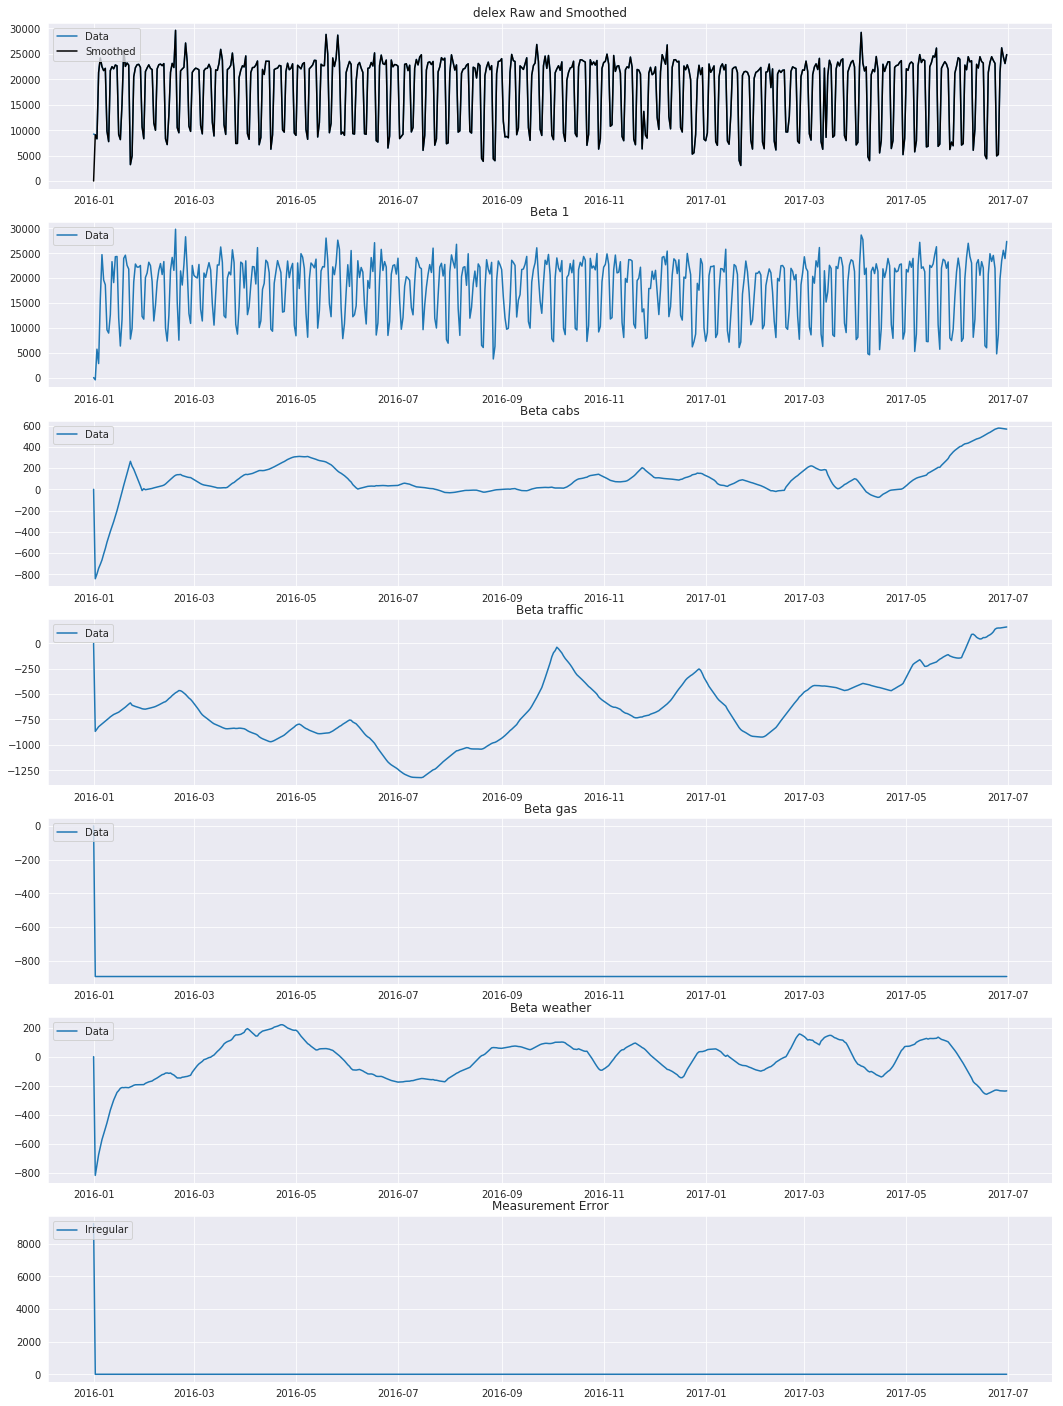

In [200]:
dyn_reg_model.plot_fit(figsize=(18,25))

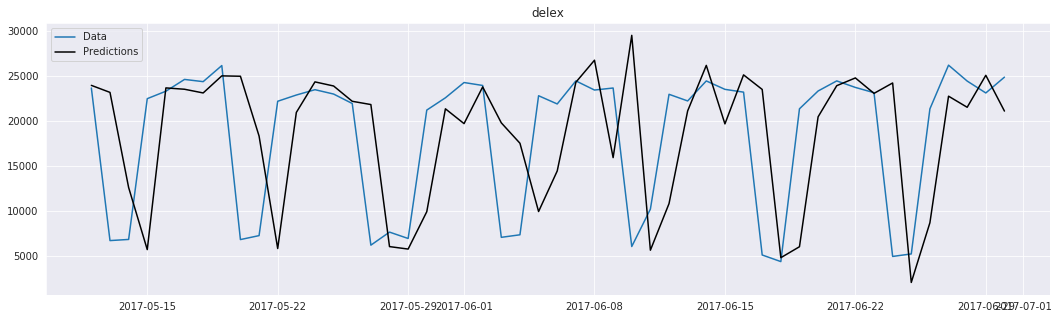

In [201]:
dyn_reg_model.plot_predict_is(h=50, figsize=(18,5))

#### Dynamic GLM

In [202]:
from pyflux import Normal
dyn_glm_model = DynamicGLM('delent ~ cabs+traffic+gas+weather', data=df, family=Normal())
dyn_glm_model_result = dyn_glm_model.fit()
dyn_glm_model_result.summary()

Dynamic Linear Regression                                                                                 
======================================================= ==================================================
Dependent Variable: delent                              Method: MLE                                       
Start Date: 2016-01-01 00:00:00                         Log Likelihood: -5876.1663                        
End Date: 2017-06-30 00:00:00                           AIC: 11764.3326                                   
Number of observations: 547                             BIC: 11790.1593                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Sigma^2 irregular                        0.0509                                                           
Sigma^2 1                            

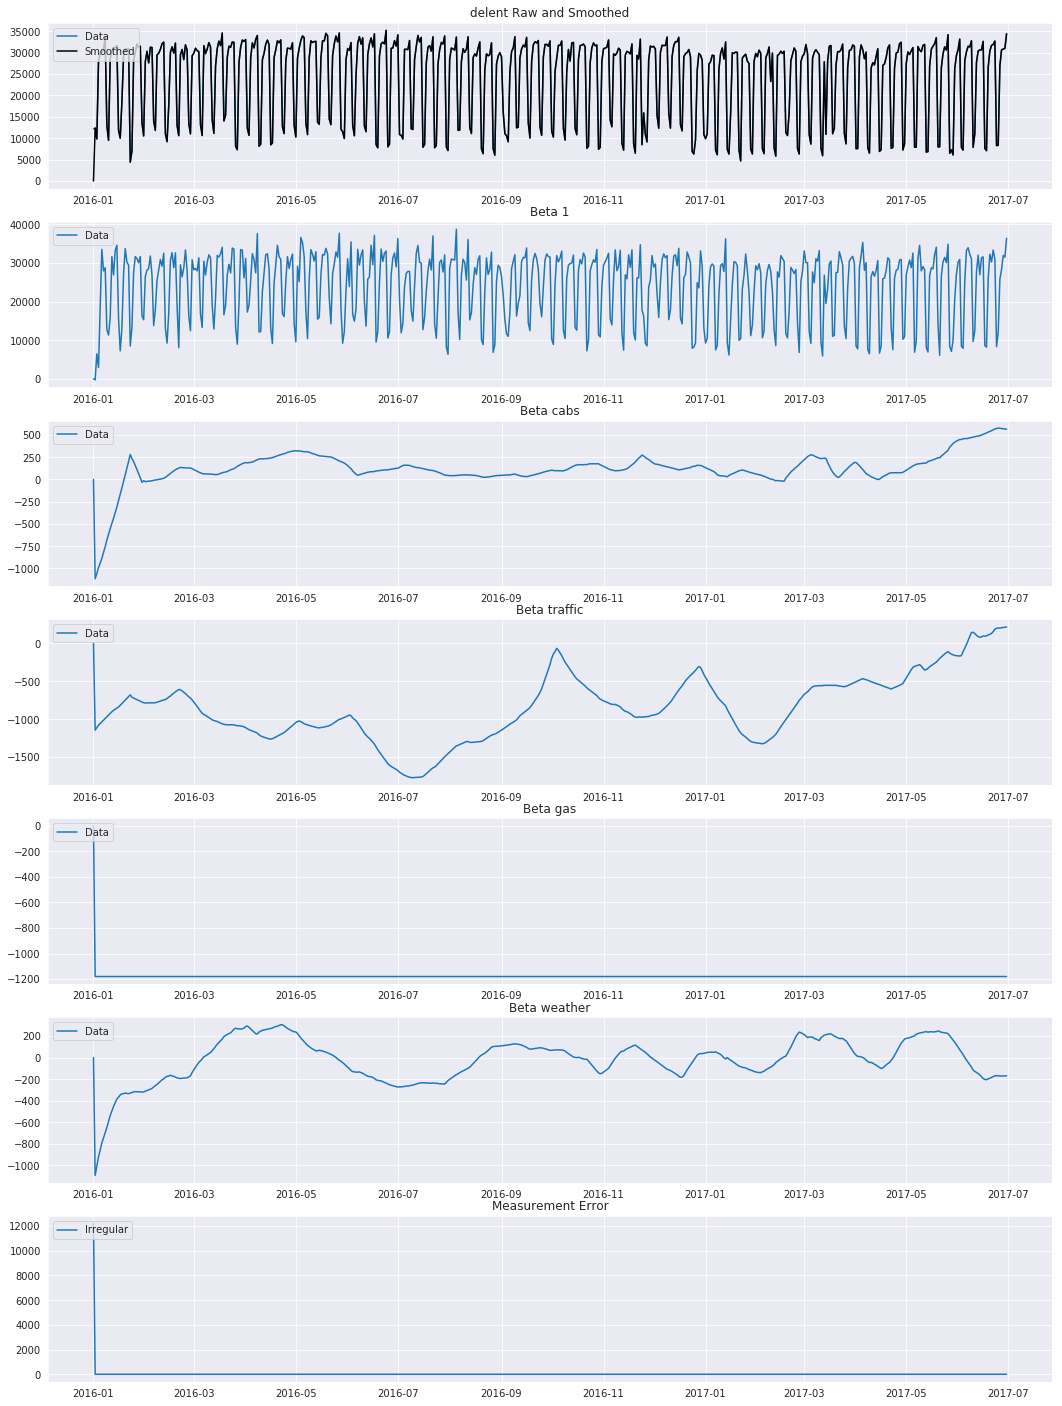

In [203]:
dyn_glm_model.plot_fit(figsize=(18,25))

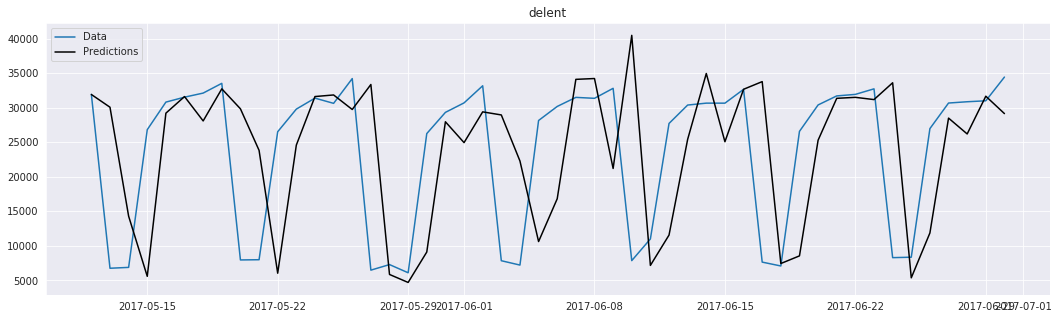

In [204]:
dyn_glm_model.plot_predict_is(h=50, figsize=(18,5))

### GAS Regression Model

In [205]:
from pyflux import GASReg
gas_gaus_model = GASReg(formula='delex~cabs+traffic+gas+weather',data=df, family=Normal())
gas_gaus_model_result = gas_gaus_model.fit()

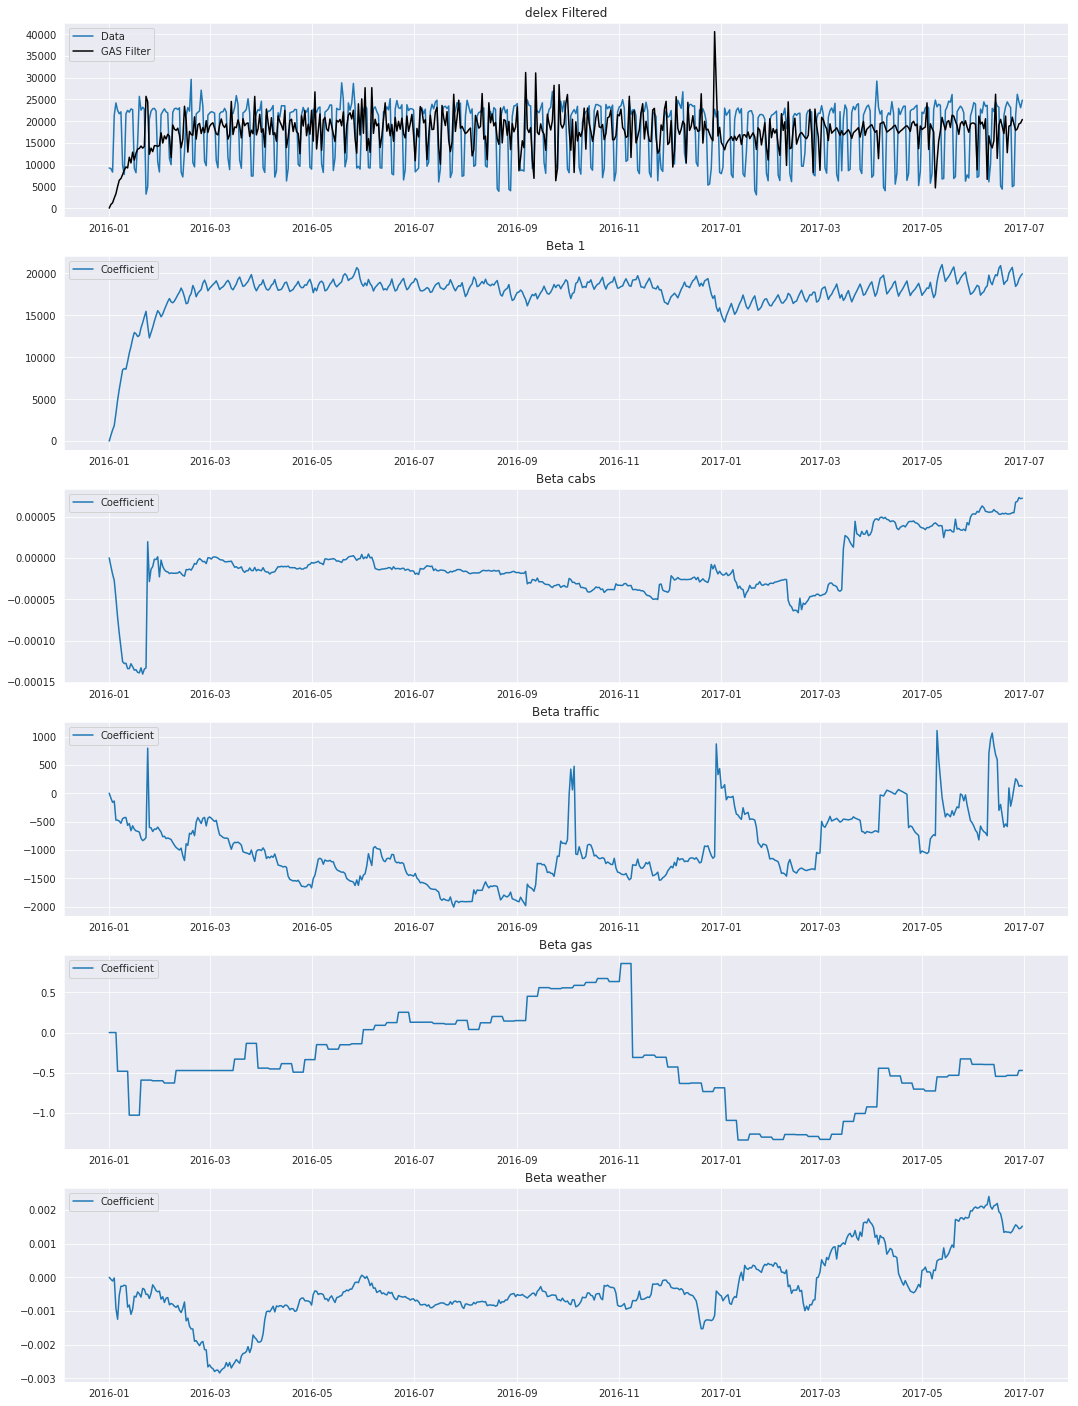

In [206]:
gas_gaus_model.plot_fit(figsize=(18,25))

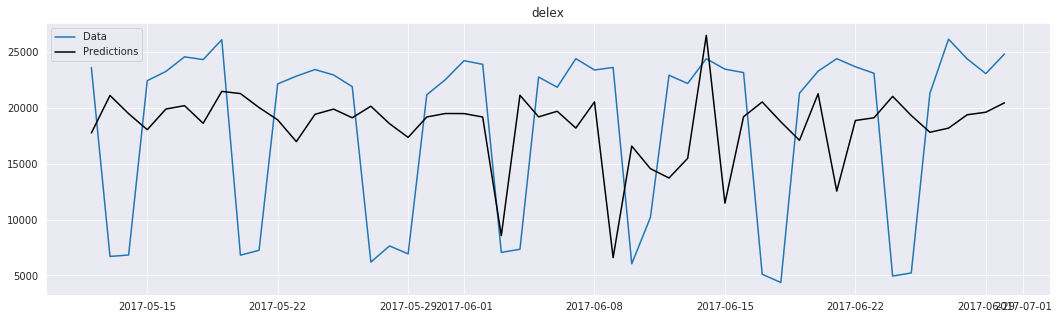

In [207]:
gas_gaus_model.plot_predict_is(h=50, figsize=(18,5))

In [208]:
gas_gaus_model2 = GASReg(formula='delent~cabs+traffic+gas+weather',data=df, family=Normal())
gas_gaus_model_result2 = gas_gaus_model2.fit()

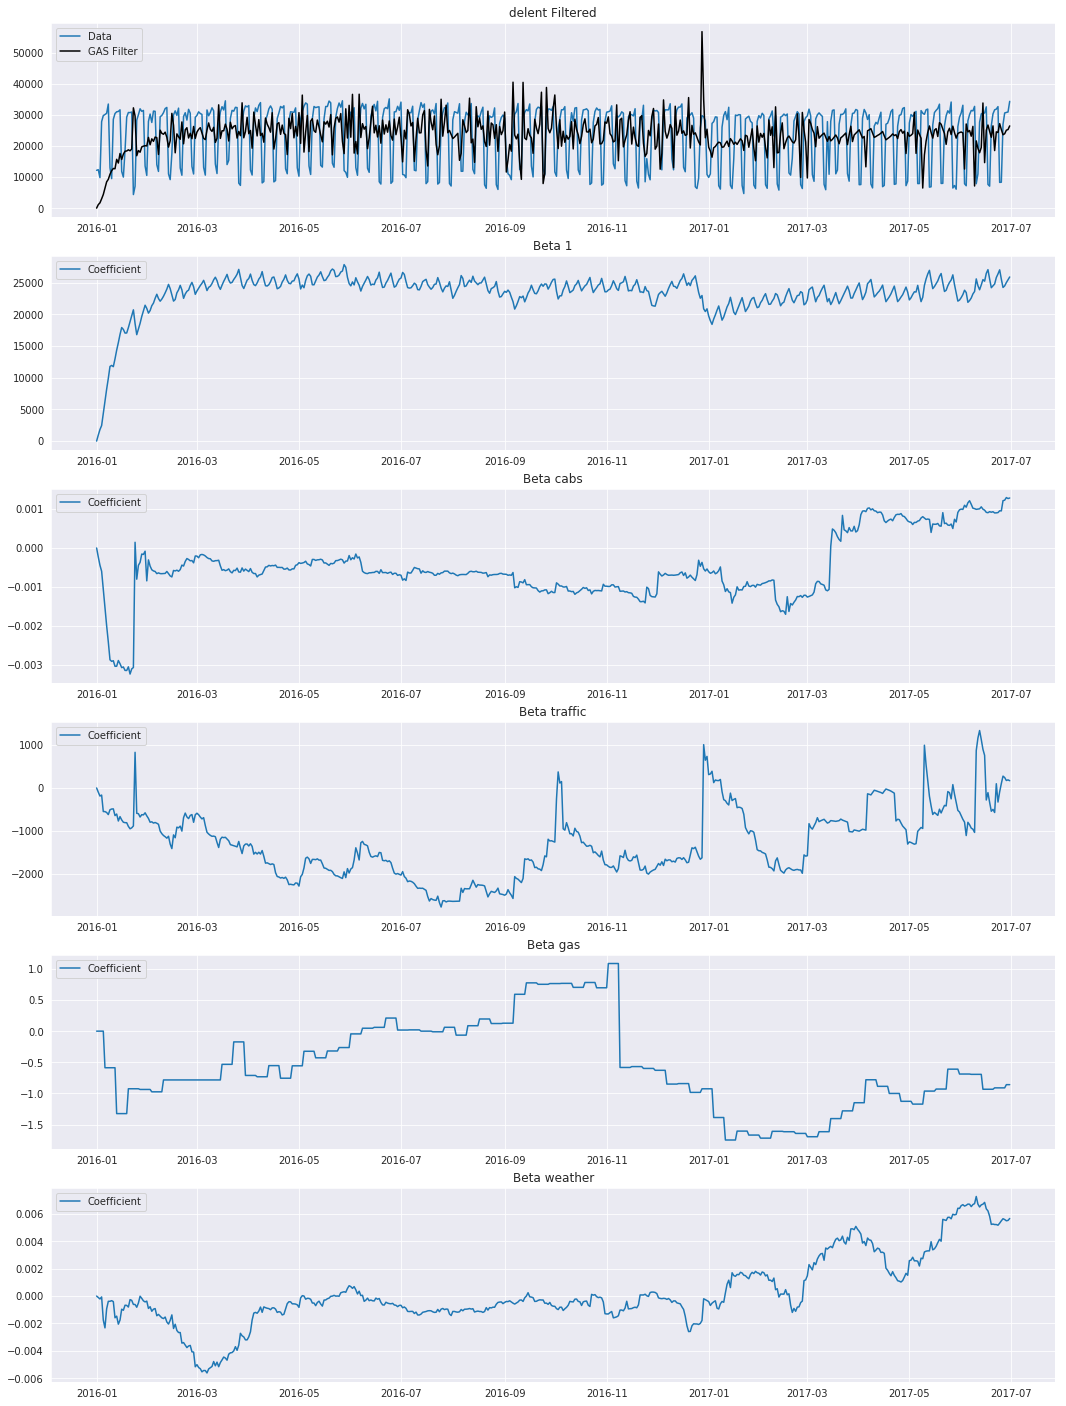

In [209]:
gas_gaus_model2.plot_fit(figsize=(18,25))

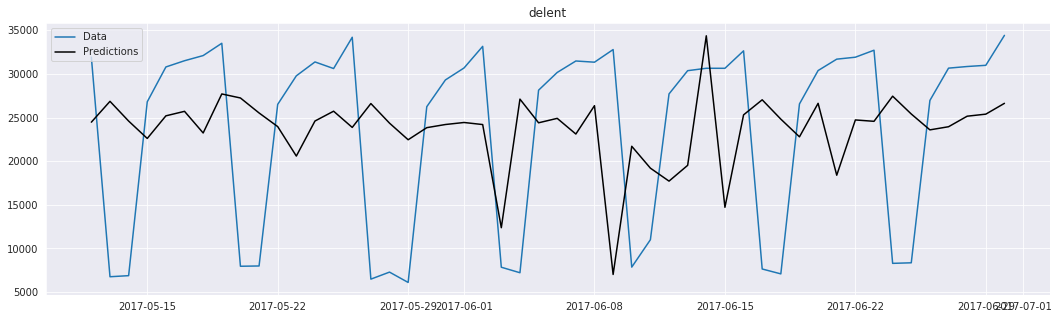

In [210]:
gas_gaus_model2.plot_predict_is(h=50, figsize=(18,5))

### Beta-t-EGARCH Regression Model

In [211]:
from pyflux import EGARCHMReg

In [212]:
def optimize_beta_t_egarch(data, var_col, p_max=4, q_max=4):
    aic = DataFrame(zeros((p_max,q_max), dtype=float))
    bic = DataFrame(zeros((p_max,q_max), dtype=float))
    for p in range(1,p_max+1):
        for q in range(1,q_max+1):
            egarch_model = EGARCHMReg(p=p,q=q,data=data,formula=var_col+' ~ cabs+traffic+gas+weather')
            try:
                egarch_model_result = egarch_model.fit()
                aic.iloc[p-1,q-1] = egarch_model_result.aic
                bic.iloc[p-1,q-1] = egarch_model_result.bic
            except:
                aic.iloc[p-1,q-1] = nan
                bic.iloc[p-1,q-1] = nan
    q = aic.min().idxmin()
    p = aic.idxmin()[q]
    return p, q

In [213]:
p_egarch, q_egarch = optimize_beta_t_egarch(data=df, var_col='delex', p_max=4, q_max=4)
print('optimum order for passsengers exiting (delex)= {:d},{:d}'.format(p_egarch,q_egarch))

optimum order for passsengers exiting (delex)= 2,2


In [214]:
egarch_model = EGARCHMReg(p=p_egarch,q=q_egarch,data=df,formula='delex ~ cabs+traffic+gas+weather')
egarch_model_result = egarch_model.fit()
egarch_model_result.summary()

EGARCHMReg(2,2)                                                                                           
======================================================= ==================================================
Dependent Variable: delex                               Method: MLE                                       
Start Date: 2016-01-03 00:00:00                         Log Likelihood: -5575.6296                        
End Date: 2017-06-30 00:00:00                           AIC: 11183.2592                                   
Number of observations: 545                             BIC: 11252.0718                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
p(1)                                     0.8167                                                           
p(2)                                 

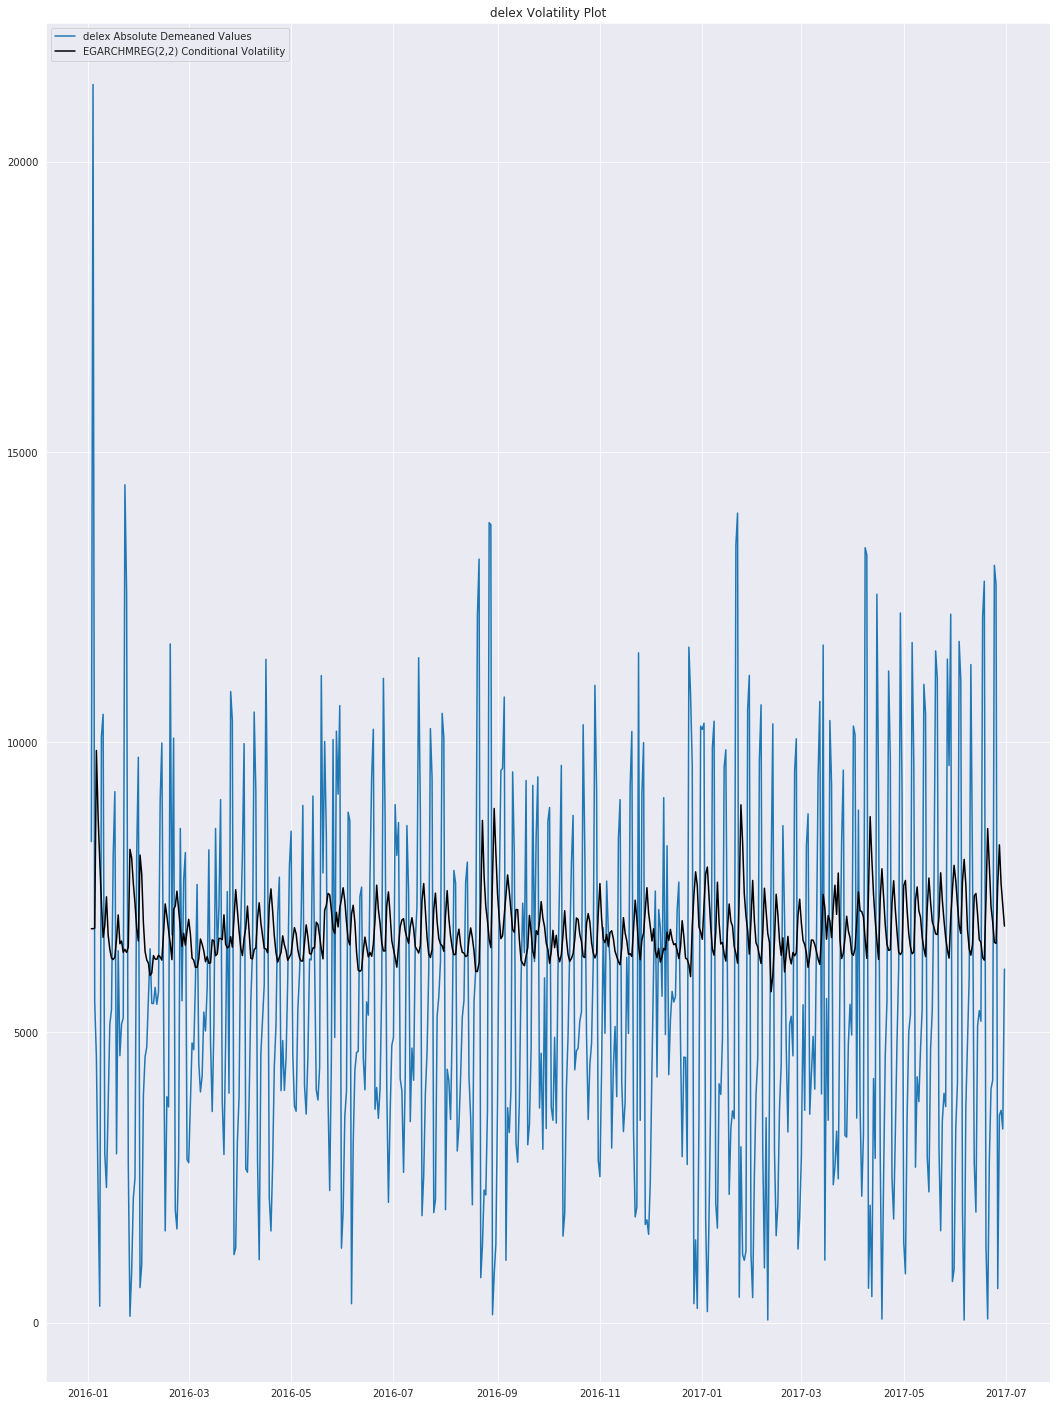

In [215]:
egarch_model.plot_fit(figsize=(18,25))